In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
from IPython.display import Markdown
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
load_dotenv()
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
from src.schema.decisions import Decision
from src.doc_store.cap_client import CAPClient
from src.doc_store.cl_client  import CourtListenerClient
from src.doc_store.utils import (
    load_models_from_json, 
)

In [3]:
cl_client = CourtListenerClient()
cap_client = CAPClient()

In [4]:
cap_docket_search = cap_client.search_cases(search_term="Liberty Mutual", full_case=True)

* The `Decision` data model is based on the CAP API, but it also (mostly) works with Court Listener API data

In [5]:
decisions = [Decision(**result) for result in cap_docket_search["results"]]

decisions[0].casebody.status

'ok'

In [6]:
len(decisions)

100

In [3]:
decisions = load_models_from_json(Decision, "./data/models/top_four.json")
len(decisions)

169

* Example of CAP data

In [7]:
cap_client.download_to_csv(cap_docket_search, 'cap_liberty_search_results.csv')

Downloaded 58129 court cases to file cap_liberty_search_results.csv.


In [8]:
cap_df = cap_client.read_in_csv('cap_liberty_search_results.csv')
print(f"Shape of CAP keyword search results: {cap_df.shape}")
print(f"Data contains {cap_df['name'].nunique():,} unique case names")
cap_df.head(2)

Shape of CAP keyword search results: (58129, 13)
Data contains 56,716 unique case names


,id,name,name_abbreviation,decision_date,court_id,court_name,court_slug,judges,attorneys,citations,url,head,body
0,9468099,"Lauri Jo HARTZ, Plaintiff-Appellant, v. LIBERT...",Hartz v. Liberty Mutual Insurance,2001-10-29,8954,United States Court of Appeals for the Fourth ...,4th-cir,"['Before WILKINSON, Chief Judge, and WILKINS a...","['ARGUED: C. William Michaels, Baltimore, MD, ...","[{'type': 'official', 'cite': '269 F.3d 474'}]",https://api.case.law/v1/cases/9468099/,"Lauri Jo HARTZ, Plaintiff-Appellant, v. LIBERT...",Affirmed by published opinion. Chief Judge WIL...
1,6774574,"Reynolds v. Liberty Mutual Insurance Company, ...",Reynolds v. Liberty Mutual Insurance,1975-11-13,8775,Superior Court of Pennsylvania,pa-super-ct,[],"['Stephen J. Schofield, with him Joseph R. Tho...","[{'type': 'official', 'cite': '236 Pa. Super. ...",https://api.case.law/v1/cases/6774574/,"Reynolds v. Liberty Mutual Insurance Company, ...",Order and judgment in both appeals affirmed.


In [10]:
cap_df['name'].fillna('Missing', inplace=True)
cap_df['body'].fillna('Missing', inplace=True)

cap_df['name_contains_lm'] = cap_df['name'].apply(lambda x: 'Liberty Mutual' in x or 'LIBERTY MUTUAL' in x)
cap_df['body_contains_lm'] = cap_df['body'].apply(lambda x: 'Liberty Mutual' in x or 'LIBERTY MUTUAL' in x)
    
cap_df['name_contains_lm'].value_counts()

name_contains_lm
False    51916
True      6213
Name: count, dtype: int64

In [11]:
cap_df['body_contains_lm'].value_counts()

body_contains_lm
False    56589
True      1540
Name: count, dtype: int64

In [12]:
# Filtering the dataframe to keep rows where either 'name_contains_lm' or 'body_contains_lm' is True
filtered_df = cap_df[(cap_df['name_contains_lm'] == True) | (cap_df['body_contains_lm'] == True)]

print(f"Filtered df shape: {filtered_df.shape}")
filtered_df.head(2)

Filtered df shape: (7467, 15)


,id,name,name_abbreviation,decision_date,court_id,court_name,court_slug,judges,attorneys,citations,url,head,body,name_contains_lm,body_contains_lm
0,9468099,"Lauri Jo HARTZ, Plaintiff-Appellant, v. LIBERT...",Hartz v. Liberty Mutual Insurance,2001-10-29,8954,United States Court of Appeals for the Fourth ...,4th-cir,"['Before WILKINSON, Chief Judge, and WILKINS a...","['ARGUED: C. William Michaels, Baltimore, MD, ...","[{'type': 'official', 'cite': '269 F.3d 474'}]",https://api.case.law/v1/cases/9468099/,"Lauri Jo HARTZ, Plaintiff-Appellant, v. LIBERT...",Affirmed by published opinion. Chief Judge WIL...,True,True
1,6774574,"Reynolds v. Liberty Mutual Insurance Company, ...",Reynolds v. Liberty Mutual Insurance,1975-11-13,8775,Superior Court of Pennsylvania,pa-super-ct,[],"['Stephen J. Schofield, with him Joseph R. Tho...","[{'type': 'official', 'cite': '236 Pa. Super. ...",https://api.case.law/v1/cases/6774574/,"Reynolds v. Liberty Mutual Insurance Company, ...",Order and judgment in both appeals affirmed.,True,False


In [13]:
filtered_df['decision_date'] = pd.to_datetime(filtered_df['decision_date'], errors='coerce')
filtered_df.sort_values(by='decision_date', inplace=True)
filtered_df['decision_date'].min(), filtered_df['decision_date'].max()

(Timestamp('1910-05-12 00:00:00'), Timestamp('2019-08-15 00:00:00'))

<Axes: >

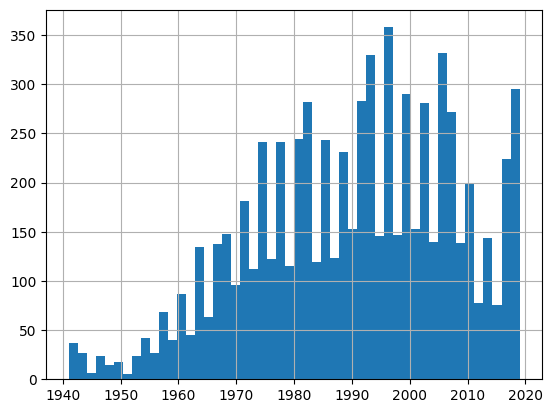

In [14]:
filtered_df['year'] = pd.DatetimeIndex(filtered_df['decision_date']).year
filtered_df['year'] = filtered_df['year'].fillna(0).astype(int)
trimmed_df = filtered_df[filtered_df['year'] > 1940]
trimmed_df['year'].hist(bins=50)

In [15]:
df1 = filtered_df[filtered_df['year']>=2000]

print(f"df shape: {df1.shape}")
print(f"unique case names: {df1['name'].nunique():,}")
df1.head(2)

df shape: (2479, 16)
unique case names: 2,359


,id,name,name_abbreviation,decision_date,court_id,court_name,court_slug,judges,attorneys,citations,url,head,body,name_contains_lm,body_contains_lm,year
3546,106582,"Nancy RAMIREZ, as Personal Representative of t...","Ramirez v. Dawson Production Partners, Inc.",2000-01-11,9025,Court of Appeals of New Mexico,nm-ct-app,"['BOSSON and ARMIJO, JJ., concur.']","['Timothy J. Cusack, Cusack, Jaramillo, Romero...","[{'type': 'official', 'cite': '128 N.M. 601'},...",https://api.case.law/v1/cases/106582/,2000-NMCA-011\r\n995 P.2d 1043\r\nNancy RAMIRE...,"OPINION\r\nBUSTAMANTE, Judge.\r\n{1} This case...",True,False,2000
30161,411690,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",Johnson v. Halloran,2000-01-13,8837,Illinois Appellate Court,ill-app-ct,[],"['Wolter, Beeman, Lynch & McIntyre, of Springf...","[{'type': 'official', 'cite': '312 Ill. App. 3...",https://api.case.law/v1/cases/411690/,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",JUSTICE HALL\r\ndelivered the opinion of the c...,False,True,2000


In [16]:
from src.utils.citations import create_citation_lookup_table, get_top_citations, get_citation_context

In [17]:
top_citations = get_top_citations(df=df1, text_column='body', top_n=50)
Markdown(top_citations.to_markdown(index=False))

| Citation             |   Count | link                                                  |
|:---------------------|--------:|:------------------------------------------------------|
| 154 Ill. 2d 90       |     321 | https://cite.case.law/ill-2d/154/90                   |
| 607 N.E.2d 1204      |     178 | https://cite.case.law/ne2d/607/1204                   |
| 156 Ill. 2d 384      |      76 | https://cite.case.law/ill-2d/156/384                  |
| 477 U.S. 317         |      60 | https://cite.case.law/us/477/317                      |
| 144 Ill. 2d 64       |      59 | https://cite.case.law/ill-2d/144/64                   |
| 106 S. Ct. 2548      |      56 | https://www.courtlistener.com/c/S.%20Ct./106/2548     |
| 91 L. Ed. 2d 265     |      56 | https://www.courtlistener.com/c/L.%20Ed.%202d/91/265  |
| 477 U.S. 242         |      44 | https://cite.case.law/us/477/242                      |
| 91 L. Ed. 2d 202     |      44 | https://www.courtlistener.com/c/L.%20Ed.%202d/91/202  |
| 106 S. Ct. 2505      |      44 | https://www.courtlistener.com/c/S.%20Ct./106/2505     |
| 197 Ill. 2d 278      |      43 | https://cite.case.law/ill-2d/197/278                  |
| 177 Ill. 2d 473      |      41 | https://cite.case.law/ill-2d/177/473                  |
| 186 Ill. 2d 127      |      37 | https://cite.case.law/ill-2d/186/127                  |
| 620 N.E.2d 1073      |      37 | https://cite.case.law/ne2d/620/1073                   |
| 578 N.E.2d 926       |      37 | https://cite.case.law/ne2d/578/926                    |
| 111 Ill. 2d 229      |      34 | https://cite.case.law/ill-2d/111/229                  |
| 215 Ill. 2d 121      |      32 | https://cite.case.law/ill-2d/215/121                  |
| 180 Ill. Dec. 691    |      32 | https://www.courtlistener.com/c/Ill.%20Dec./180/691   |
| 213 Ill. 2d 141      |      25 | https://cite.case.law/ill-2d/213/141                  |
| 213 Ill. 2d 307      |      24 | https://cite.case.law/ill-2d/213/307                  |
| 155 Ill. 2d 402      |      23 | https://cite.case.law/ill-2d/155/402                  |
| 757 N.E.2d 481       |      23 | https://cite.case.law/ne2d/757/481                    |
| 106 S. Ct. 1348      |      23 | https://www.courtlistener.com/c/S.%20Ct./106/1348     |
| 89 L. Ed. 2d 538     |      23 | https://www.courtlistener.com/c/L.%20Ed.%202d/89/538  |
| 708 N.E.2d 1122      |      22 | https://cite.case.law/ne2d/708/1122                   |
| 118 Ill. 2d 23       |      22 | https://cite.case.law/ill-2d/118/23                   |
| 475 U.S. 574         |      22 | https://cite.case.law/us/475/574                      |
| 166 Ill. 2d 520      |      21 | https://cite.case.law/ill-2d/166/520                  |
| 687 N.E.2d 72        |      20 | https://cite.case.law/ne2d/687/72                     |
| 165 Ill. 2d 107      |      20 | https://cite.case.law/ill-2d/165/107                  |
| 214 Ill. 2d 11       |      20 | https://cite.case.law/ill-2d/214/11                   |
| 550 U.S. 544         |      19 | https://cite.case.law/us/550/544                      |
| 556 U.S. 662         |      19 | https://cite.case.law/us/556/662                      |
| 129 S. Ct. 1937      |      19 | https://www.courtlistener.com/c/S.%20Ct./129/1937     |
| 173 L. Ed. 2d 868    |      19 | https://www.courtlistener.com/c/L.%20Ed.%202d/173/868 |
| 268 Ill. App. 3d 598 |      18 | https://cite.case.law/ill-app-3d/268/598              |
| 309 Ill. App. 3d 313 |      18 | https://cite.case.law/ill-app-3d/309/313              |
| 374 Ill. App. 3d 618 |      18 | https://cite.case.law/ill-app-3d/374/618              |
| 127 S. Ct. 1955      |      18 | https://www.courtlistener.com/c/S.%20Ct./127/1955     |
| 167 L. Ed. 2d 929    |      18 | https://www.courtlistener.com/c/L.%20Ed.%202d/167/929 |
| 183 Ill. 2d 317      |      17 | https://cite.case.law/ill-2d/183/317                  |
| 181 Ill. 2d 436      |      17 | https://cite.case.law/ill-2d/181/436                  |
| 349 N.C. 676         |      17 | https://cite.case.law/nc/349/676                      |
| 509 S.E.2d 411       |      17 | https://cite.case.law/se2d/509/411                    |
| 328 Ill. App. 3d 696 |      17 | https://cite.case.law/ill-app-3d/328/696              |
| 323 Ill. App. 3d 946 |      17 | https://cite.case.law/ill-app-3d/323/946              |
| 230 Ill. App. 3d 40  |      17 | https://cite.case.law/ill-app-3d/230/40               |
| 489 N.E.2d 867       |      16 | https://cite.case.law/ne2d/489/867                    |
| 88 Ill. 2d 1         |      15 | https://cite.case.law/ill-2d/88/1                     |
| 186 Ill. 2d 367      |      15 | https://cite.case.law/ill-2d/186/367                  |

In [18]:
top_cite = '154 Ill. 2d 90'

top_cited_case = cap_client.read_cite(
    cite=top_cite,
    full_case=True,
    body_format='html')
print(top_cited_case)

Outboard Marine Corp. v. Liberty Mutual Insurance, 154 Ill. 2d 90 (1992-12-04)


In [19]:
top_cited_case.frontend_pdf_url

'https://cite.case.law/pdf/4820940/Outboard%20Marine%20Corp.%20v.%20Liberty%20Mutual%20Insurance,%20154%20Ill.%202d%2090%20(1992).pdf'

In [21]:
from src.utils.gen_utils import count_tokens

case_text = top_cited_case.construct_decision_string()
count_tokens(case_text)

18007

In [22]:
from typing import List
from typing_extensions import Annotated
from pydantic import BaseModel, Field
from src.utils.pydantic_utils import flatten_pydantic_instance
from tenacity import Retrying, stop_after_attempt, wait_fixed
import instructor
import openai

class AnalysisSection(BaseModel):
    """A concise legal analysis leading to a decision."""
    
    rules: str = Field(
        ...,
        description="Concise explanation of how the Court considers relevant statutes, interpretations, standards, and tests applicable to this case.",
    )
    case_law: str = Field(
        ...,
        description="Names and or citations of cases reviewed by the Court and analysis of how the Court relates those cases to the Issues Presented.",
    )
    application: str = Field(
        ...,
        description="Concise explanation of how the Rules and Case Law help the Court reach its conclusions.",
    )


class CaseBrief(BaseModel):
    """A well structured and concise legal case brief."""
    
    case_name: str = Field(
        ...,
        description="The name of the case, if possible include the court and year.",
    )
    issues_presented: str = Field(
        ...,
        description="The issues the Court must resolve.",
    )
    facts_of_the_case: str = Field(
        ...,
        description="A concise summary of the facts, parties involved, and the events leading to this case.",
    )
    procedural_history: str = Field(
        ...,
        description="A district court case summary, appeals court case summary, or otherwise how this issue reached this Court.",
    )
    analysis: AnalysisSection = Field(
        ...,
        description="A legal analysis leading to a decision.",
    )
    conclusion: str = Field(
        ...,
        description="The Court's ruling on the Issues Presented.",
    )
    winner: str = Field(
        ...,
        description="The entity or role that the Court decided in favor of.",
    )
    @property
    def to_pandas(self) -> pd.DataFrame:
        """Converts the case brief into a pandas DataFrame."""
        flat_model = flatten_pydantic_instance(self)
        return pd.DataFrame([flat_model])
    
    def __str__(self) -> str:
        """Returns a structured legal case brief as a string."""
        brief_details = [
            f"Case Name: {self.case_name}",
            f"Issues Presented: {self.issues_presented}",
            f"Facts of the Case: {self.facts_of_the_case}",
            f"Procedural History: {self.procedural_history}",
            f"Analysis:\n\n* Rules: {self.analysis.rules}\n\n* Case Law: {self.analysis.case_law}\n\n* Application: {self.analysis.application}",
            f"Conclusion: {self.conclusion}",
            f"Winner: {self.winner}"
        ]
        return "\n\n".join(brief_details)

    
CaseBrief.model_rebuild()


def generate_case_brief(text: str) -> CaseBrief:
    client = instructor.patch(openai.OpenAI())
    return client.chat.completions.create(
        model="gpt-4-1106-preview",
        response_model=CaseBrief,
        max_retries=Retrying(
            stop=stop_after_attempt(5),
            wait=wait_fixed(1),
        ),
        messages=[
            {
                "role": "system",
                "content": "You are a world class legal AI specializing in document extraction and summarization.",
            },
            {
                "role": "user",
                "content": f"Compose a case brief using only information from the Context. Working step by step, organize the Context outline into well-structured paragraphs.\n\nHere is the Context: {text}",
            },
        ],
    )

In [23]:
case_brief = generate_case_brief(case_text)

In [24]:
Markdown(str(case_brief))

Case Name: Outboard Marine Corp. v. Liberty Mutual Insurance, 154 Ill. 2d 90 (1992-12-04)

Issues Presented: Whether the insurers have a duty to defend and indemnify Outboard Marine Corporation (OMC) under the terms of comprehensive general liability (CGL) insurance policies, considering the pollution exclusion clauses and the known loss doctrine.

Facts of the Case: Outboard Marine Corporation (OMC) was involved in a coverage dispute with its insurers over the discharge of polychlorinated biphenyls (PCBs) into the North Ditch, Waukegan Harbor, and Lake Michigan. The Environmental Protection Agency (EPA) and the State of Illinois brought actions against OMC, which tendered defense to its insurers. The insurers refused to defend OMC, alleging the actions were not covered under the policies due to pollution exclusion provisions. OMC defended itself and later entered into a consent decree, incurring cleanup costs and seeking a declaration from the court regarding its insurers' duty to defend and indemnify for the costs associated with the PCB cleanup.

Procedural History: The circuit court of Lake County granted OMC partial summary judgment against Liberty Mutual on the 'damages' issue, but granted the insurers' motions for summary judgment based on pollution exclusion provisions. Appeals were consolidated, and the appellate court affirmed the decisions. The Illinois Supreme Court granted Liberty Mutual's petition for leave to appeal.

Analysis:

* Rules: Insurers have a duty to defend if the facts alleged in a complaint potentially fall within policy coverage. The known loss doctrine may preclude coverage if the insured knew or should have known of a probable loss when purchasing the policy. The pollution exclusion generally denies coverage for environmental damage unless the discharge is sudden and accidental. However, language in insurance contracts is subject to interpretation, and ambiguous terms are construed in favor of coverage.

* Case Law: The appellate court's interpretation of 'sudden' in the pollution exclusion clauses was reviewed, examining contrary authorities and considering the relationship between the policy definition of 'occurrence' and the exclusion clause.

* Application: The Illinois Supreme Court construed the term 'sudden' in the exclusion clauses to mean unexpected or unintended rather than abrupt. This interpretation reinstates coverage for gradual but unintentional polluting events under the CGL policies. As for the known loss doctrine, the court affirmed one insurer's summary judgment due to OMC's pre-existing knowledge of PCB pollution, but remanded for further proceedings regarding other insurers. The court also upheld an insurer's exclusion based on its distinct pollution exclusion clause which did not contain a 'sudden and accidental' exception.

Conclusion: The Illinois Supreme Court affirmed parts of both the appellate and circuit courts' rulings, reversed others, and remanded the case for further proceedings. It affirmed that OMC had knowledge of the known loss for one insurer, that the underlying actions were 'suits seeking damages', and that one insurer was rightly excluded based on its distinct clause. The court reversed the findings on the 'sudden and accidental' exception, providing possible coverage for OMC.

Winner: Partially Outboard Marine Corporation, partially the insurers

In [25]:
# %%time
citation_table = create_citation_lookup_table(df1, text_column='body', id_column='id')
print(f"Citation table contains {len(citation_table):,} rows from {citation_table['citation'].nunique():,} unique citations")

Citation table contains 30,423 rows from 22,331 unique citations
CPU times: total: 1min 38s
Wall time: 1min 38s


In [26]:
def filter_frequent_citations(citation_table: pd.DataFrame, min_occurrences: int = 10) -> pd.DataFrame:
    """
    Filters the citation table to only include citations that appear at least a specified number of times.
    
    Args:
        citation_table (pd.DataFrame): The citation table to filter.
        min_occurrences (int): The minimum number of occurrences for a citation to be included.
        
    Returns:
        pd.DataFrame: A filtered DataFrame containing only the citations that meet the minimum occurrence criterion.
    """
    # Count the occurrences of each citation
    citation_counts = citation_table['citation'].value_counts()
    
    # Filter for citations that occur at least min_occurrences times
    frequent_citations = citation_counts[citation_counts >= min_occurrences].index
    
    # Filter the original citation table to only include these citations
    filtered_citation_table = citation_table[citation_table['citation'].isin(frequent_citations)]
    
    return filtered_citation_table


In [27]:
frequent_citation_table = filter_frequent_citations(citation_table, 10)
frequent_citation_table.shape

(2669, 2)

In [28]:
df2 = frequent_citation_table.merge(df1, on='id', how='inner')

In [29]:
df2.head(2)

,id,citation,name,name_abbreviation,decision_date,court_id,court_name,court_slug,judges,attorneys,citations,url,head,body,name_contains_lm,body_contains_lm,year
0,411690,154 Ill. 2d 90,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",Johnson v. Halloran,2000-01-13,8837,Illinois Appellate Court,ill-app-ct,[],"['Wolter, Beeman, Lynch & McIntyre, of Springf...","[{'type': 'official', 'cite': '312 Ill. App. 3...",https://api.case.law/v1/cases/411690/,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",JUSTICE HALL\r\ndelivered the opinion of the c...,False,True,2000
1,411690,607 N.E.2d 1204,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",Johnson v. Halloran,2000-01-13,8837,Illinois Appellate Court,ill-app-ct,[],"['Wolter, Beeman, Lynch & McIntyre, of Springf...","[{'type': 'official', 'cite': '312 Ill. App. 3...",https://api.case.law/v1/cases/411690/,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",JUSTICE HALL\r\ndelivered the opinion of the c...,False,True,2000


In [30]:
print(f"shape of df with cases citing a top 10 cite: {df2.shape}")
print(f"data contains: {df2['citation'].nunique()} unique citations")

shape of df with cases citing a top 10 cite: (2669, 17)
data contains: 117 unique citations


In [31]:
def add_citation_context_to_df(
    df: pd.DataFrame, 
    text_column: str, 
    citation_column: str, 
    words_before: int = 512, 
    words_after: int = 512,
) -> pd.DataFrame:
    """
    Loops over the given DataFrame and applies `get_citation_context` for the specified citation.
    Adds the resulting context string to the DataFrame as a new column.

    Args:
        df (pd.DataFrame): The DataFrame to process, expected to contain a 'body' column.
        citation (str): The citation to search for within the 'body' column.

    Returns:
        pd.DataFrame: The original DataFrame with an added 'context' column containing the citation context.
    """
    # Ensure the 'context' column exists
    if 'context' not in df.columns:
        df['context'] = ''

    # Apply the get_citation_context function row-wise
    for index, row in df.iterrows():
        cite = row[citation_column]
        context = get_citation_context(
            text=row[text_column], 
            citation=cite, 
            words_before=words_before, 
            words_after=words_after,
        )
        df.at[index, 'context'] = context
        df.at[index, 'context_citation'] = cite

    return df

In [32]:
top_cites_with_context_df = add_citation_context_to_df(
    df=df2,
    text_column='body',
    citation_column='citation',
)

In [38]:
top_cites_with_context_df['context_tokens'] = top_cites_with_context_df['context'].apply(lambda x: count_tokens(x))
top_cites_with_context_df['context_tokens'].describe()

count    2669.000000
mean     1435.885725
std       153.952959
min       568.000000
25%      1365.000000
50%      1428.000000
75%      1524.000000
max      2216.000000
Name: context_tokens, dtype: float64

In [39]:
top_cites_with_context_df['context_tokens'].sum()

3832379

In [35]:
top_cites_with_context_df.head(2)

,id,citation,name,name_abbreviation,decision_date,court_id,court_name,court_slug,judges,attorneys,citations,url,head,body,name_contains_lm,body_contains_lm,year,context,context_citation,context_tokens
0,411690,154 Ill. 2d 90,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",Johnson v. Halloran,2000-01-13,8837,Illinois Appellate Court,ill-app-ct,[],"['Wolter, Beeman, Lynch & McIntyre, of Springf...","[{'type': 'official', 'cite': '312 Ill. App. 3...",https://api.case.law/v1/cases/411690/,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",JUSTICE HALL\r\ndelivered the opinion of the c...,False,True,2000,The public defender of Cook County was appoint...,154 Ill. 2d 90,1317
1,411690,607 N.E.2d 1204,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",Johnson v. Halloran,2000-01-13,8837,Illinois Appellate Court,ill-app-ct,[],"['Wolter, Beeman, Lynch & McIntyre, of Springf...","[{'type': 'official', 'cite': '312 Ill. App. 3...",https://api.case.law/v1/cases/411690/,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",JUSTICE HALL\r\ndelivered the opinion of the c...,False,True,2000,The public defender of Cook County was appoint...,607 N.E.2d 1204,1317


In [40]:
top_cites_with_context_df.to_parquet('citation_data_with_context.parquet', index=False)

In [4]:
top_cites_with_context_df = pd.read_parquet('citation_data_with_context.parquet')

In [5]:
from src.utils.citations import create_highlighted_citation

example_context = top_cites_with_context_df['context'].tolist()[2]
example_citation = top_cites_with_context_df['citation'].tolist()[2]

html_text = create_highlighted_citation(
    text=example_context,
    target_citation=example_citation,
    html=True)

Markdown(html_text)

The defense in the criminal case was then assigned to assistant public defender Halloran. Pretrial discovery disclosed by the State in the criminal case included two Chicago police department lab reports. These lab reports showed that body fluids on the vaginal swab and panties of the victim immediately following the attack revealed the presence of H activity, indicating that such body fluids were from a person who was a secretor. The blood and saliva samples taken from the victim and from Johnson showed that they were both nonsecretors. These results established that Johnson could not have been the sole donor of the foreign body fluids found on the person or clothing of the victim. Halloran did not seek to use this information in the underlying criminal trial. Rather, at a pretrial hearing, Halloran presented a motion in limine to prohibit the State from introducing any evidence of blood, semen, or saliva testing. The circuit court granted Halloran’s motion in limine on September 4, 1992. Following a bench trial, Johnson was convicted in the underlying criminal case and was sentenced to 30 years in the Illinois Department of Corrections. Prior to this conviction, no DNA profile was performed on Johnson, the victim, or the victim’s husband. Johnson’s conviction was vacated on March 8, 1996, pursuant to a postconviction petition based on DNA test results. Prior to his release, Johnson sent a letter dated February 8, 1993, to defendant Rita A. Fry, public defender of Cook County, complaining about the legal representation he received in his criminal case. In this letter, Johnson specifically mentioned DNA evidence. Johnson also sent a letter to the Attorney Registration and Disciplinary Commission (ARDC) date stamped March 3, 1993, complaining about the legal representation he received from Halloran. In the instant case, defendants filed a motion to dismiss plaintiffs complaint based on the statute of limitations, which was denied. Defendants filed a motion for summary judgment on the basis of sovereign immunity, arguing that public defenders are employees of the state and therefore the circuit court lacked subject matter jurisdiction to hear this case because plaintiffs claims must be brought in the Illinois Court of Claims. The circuit court granted defendants’ motion on May 27, 1998. On appeal plaintiff contends that the circuit court erred in granting summary judgment in favor of the defendants on the basis of sovereign immunity because (a) public defenders are not agents or employees of the state, and (b) defendants’ professional duties to their clients do not arise solely as a result of their government employment. On cross-appeal defendants contend that the circuit court erred in finding that plaintiffs complaint was timely filed. DISCUSSION A. Standard of Review In appeals from summary judgment rulings, this court conducts a de novo review. Outboard Marine Corp. v. Liberty Mutual Insurance Co., 154 Ill. 2d 90, 607 N.E.2d 1204 (1992). Summary judgment is appropriate only when there are no genuine issues of material fact and the moving party is entitled to judgment as a matter of law. Purtill v. Hess, <mark>111 Ill. 2d 229</mark>, 489 N.E.2d 867 (1986). B. Sovereign Immunity Article XIII, section 4, of the Illinois Constitution of 1970 abolished sovereign immunity “[ejxcept as the General Assembly may provide by law.” Ill. Const. 1970, art. XIII, § 4. The legislature enacted the State Lawsuit Immunity Act, which provides in pertinent part: “Except as provided in *** ‘AN ACT to create the Court of Claims ***’, *** the State of Illinois shall not be made a defendant or party in any court.” 745 ILCS 5/1 (West 1996). The Court of Claims Act established the Court of Claims and endowed it with exclusive jurisdiction to hear certain matters, including “[a]ll claims against the State for damages in cases sounding in tort, if a like cause of action would lie against a private person or corporation in a civil suit.” 705 ILCS 505/8(d) (West 1996). The plaintiff argues that Cook County public defenders are county employees and, therefore, the circuit court erred in applying the doctrine of sovereign immunity. Defendants contend that they are employees of the state so that sovereign immunity would apply. 1. Source of Duty Whether or not public defenders are state employees or county employees, the circuit court erred in applying sovereign immunity in this case because defendants’ professional duties to their clients did not arise solely as a result of their government employment. Whether an action is a suit against the state or merely an action against an employee for his own individual acts of negligence depends upon the issues involved and the relief sought, rather than the formal designation of the parties. Currie v. Lao, 148 Ill. 2d 151, 592 N.E.2d 977 (1992); Healy v. Vaupel, 133 Ill. 2d 295, 549 N.E.2d 1240 (1990). A suit against a state employee in his individual capacity is a claim against the state when the judgment for the plaintiff could control the state’s actions or subject it to liability. Wozniak v. Conry, 288 Ill. App. 3d 129, 679 N.E.2d 1255 (1997). However, a state employee is not immunized by sovereign immunity for his own acts of negligence merely because he was acting within the scope of his employment. Currie, 148 Ill. 2d at 158; Wozniak, 288 Ill. App. 3d at 133. The supreme court has instructed that when determining whether a tort claim arising out of the alleged on-the-job negligence of a state employee is in reality a claim against the state, the proper inquiry is into the source of the duty the employee is charged with breaching. Currie, 148 Ill. 2d at 159. The supreme court explained the source-of-duty analysis as follows: “Where the charged act of negligence arose out of the State employee’s breach of a duty that is imposed on him solely by virtue of his State employment, sovereign immunity will bar maintenance of the action in circuit court. [Citations.] Conversely, where the employee is charged with breaching a duty imposed on him independently of his State employment, sovereign immunity will not attach and a negligence claim may be maintained against him in circuit court. [Citations.] In other words, where

In [8]:
import pandas as pd
from typing import List
from typing_extensions import Annotated
from pydantic import BaseModel, Field
from typing import Literal
from tenacity import AsyncRetrying, stop_after_attempt, wait_fixed
import instructor
import openai
from tqdm.asyncio import tqdm

class CaseCitationReference(BaseModel):
    """A legal citation referenced in court document."""
    
    summary: str = Field(
        ...,
        description="A summary the legal argument with respect to the citation of interest. When possible this should include the question or issue the cited case helped answer or address."
    )
    keywords: str = Field(
        ...,
        description='A list of keywords useful for associating the citation with its underlying topic.'
    )

async def analyze_citations(citation: str, context: str) -> CaseCitationReference:
    """
    Asynchronously analyzes citations and returns a CaseCitationReference object.
    
    Args:
        citation (str): The citation to analyze.
        context (str): The context in which the citation is used.
        
    Returns:
        CaseCitationReference: An object containing the summary and sentiment of the citation.
    """
    client = instructor.patch(openai.AsyncOpenAI())
    response = await client.chat.completions.create(
        model="gpt-3.5-turbo",
        response_model=CaseCitationReference,
        max_retries=AsyncRetrying(
            stop=stop_after_attempt(3),
            wait=wait_fixed(1),
        ),
        messages=[
            {
                "role": "system",
                "content": "Your role is to extract information about a legal citation using the context, which is an excerpt from a subsequent legal proceeding that referenced the citation of interest.",
            },
            {   "role": "user", 
                "content": f"Your task focuses on citation: **{citation}**"},
            {   "role": "user", 
                "content": f"Here is the context: {context}"}
        ]
    )
    return response

async def process_citations_with_progress(df: pd.DataFrame) -> pd.DataFrame:
    """
    Asynchronously processes citations in a DataFrame and updates it with new attributes.
    
    Args:
        df (pd.DataFrame): The DataFrame to process.
        
    Returns:
        pd.DataFrame: The updated DataFrame with new attributes.
    """
    # Ensure the DataFrame has the necessary columns
    if 'context' not in df.columns:
        raise ValueError("DataFrame must contain a 'context' column.")
    
    # Prepare new columns for the DataFrame
    df['summary'] = None
    df['keywords'] = None
    
    # Convert DataFrame rows to a list of dictionaries for easier async processing
    rows = df.to_dict('records')
    
    # Process each row asynchronously
    async for row in tqdm(rows, total=len(rows)):
        citation_reference = await analyze_citations(row['citation'], row['context'])
        row['summary'] = citation_reference.summary
        row['keywords'] = citation_reference.keywords
    
    # Convert the list of dictionaries back to a DataFrame
    updated_df = pd.DataFrame(rows)
    
    return updated_df

In [9]:
import nest_asyncio
nest_asyncio.apply()

updated_df = await process_citations_with_progress(df=top_cites_with_context_df)

100%|██████████| 2669/2669 [1:14:46<00:00,  1.68s/it]


In [10]:
updated_df.to_parquet('citation_lookup_data.parquet', index=False)

In [11]:
df = pd.read_parquet('citation_lookup_data.parquet')

In [12]:
from IPython.display import Markdown, display

display(Markdown('\n'.join([f'* {summary}' for summary in df.sample(10)['summary'].tolist()])))

* The legal standard for summary judgment and the burden of proof in the context of a declaratory judgment action
* The case discussed in the context upheld the trial court's finding that an affidavit complied with Rule 191(a) despite technical deficiencies in identifying certain details of conversations.
* The case Crum & Forster Managers Corp. v. Resolution Trust Corp., 156 Ill. 2d 384 (1993), is cited in the legal document to support the principle that the construction of insurance policy provisions is a question of law that can be decided in a motion for summary judgment.
* The citation 106 S. Ct. 2505 is referenced in a legal proceeding discussing the standard of review for summary judgment. It states that summary judgment must be granted when there is no genuine dispute as to any material fact and the movant is entitled to judgment as a matter of law, referencing the case Anderson v. Liberty Lobby, Inc.
* The legal standard for summary judgment in the context refers to no genuine issue as to any material fact and the moving party being entitled to judgment as a matter of law. It also mentions the standard set forth in Anderson v. Liberty Lobby, Inc., 477 U.S. 242, 106 S.Ct. 2505, regarding what constitutes a genuine dispute about a material fact.
* The citation 265 N.C. 431 is referenced in a legal proceeding to illustrate the court's duty in determining whether competent evidence supports the Commission's findings of fact.
* To survive a motion to dismiss, a complaint must have 'facial plausibility,' meaning it must 'plead[ ] factual content that allows the court to draw the reasonable inference that the defendant is liable for the misconduct alleged.'
* The case of State Farm Mutual Automobile Insurance Co. v. Smith, 197 Ill. 2d 369, 757 N.E.2d 881 (2001), discusses the inappropriateness of awarding costs and sanctions when there is a bona fide dispute concerning coverage in an insurance claim.
* Crum & Forster Managers Corp. v. Resolution Trust Corp., 156 Ill. 2d 384, 393, 620 N.E.2d 1073 (1993) discusses an insurer's duty to defend and the obligation to defend its insured based on the allegations in the underlying complaint compared to the language of the insurance policy.
* The court must award summary judgment with caution to avoid preempting a litigant’s right to trial by jury or his right to present fully the factual basis of a case where a material dispute may exist. In determining a summary judgment motion, the court must construe the pleadings, affidavits, depositions and admissions on file strictly against the moving party and liberally in favor of the opponent. In re Estate of Hoover, 155 Ill. 2d 402, 410-11, 615 N.E.2d 736 (1993).

In [13]:
df.head(2)

,id,citation,name,name_abbreviation,decision_date,court_id,court_name,court_slug,judges,attorneys,citations,url,head,body,name_contains_lm,body_contains_lm,year,context,context_citation,context_tokens,summary,keywords
0,411690,154 Ill. 2d 90,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",Johnson v. Halloran,2000-01-13,8837,Illinois Appellate Court,ill-app-ct,[],"['Wolter, Beeman, Lynch & McIntyre, of Springf...","[{'type': 'official', 'cite': '312 Ill. App. 3...",https://api.case.law/v1/cases/411690/,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",JUSTICE HALL\r\ndelivered the opinion of the c...,False,True,2000,The public defender of Cook County was appoint...,154 Ill. 2d 90,1317,The case Outboard Marine Corp. v. Liberty Mutu...,"appeals, summary judgment, standard of review,..."
1,411690,607 N.E.2d 1204,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",Johnson v. Halloran,2000-01-13,8837,Illinois Appellate Court,ill-app-ct,[],"['Wolter, Beeman, Lynch & McIntyre, of Springf...","[{'type': 'official', 'cite': '312 Ill. App. 3...",https://api.case.law/v1/cases/411690/,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",JUSTICE HALL\r\ndelivered the opinion of the c...,False,True,2000,The public defender of Cook County was appoint...,607 N.E.2d 1204,1317,The case Outboard Marine Corp. v. Liberty Mutu...,"summary judgment, de novo review, genuine issu..."


In [14]:
from src.utils.gen_utils import count_tokens

df['summary_tokens'] = df['summary'].apply(lambda x: count_tokens(x))

In [15]:
def create_context(
    df: pd.DataFrame,
    context_token_limit: int = 50000
) -> str:
    """
    Creates a context string from a DataFrame within a specified token limit.

    Args:
        df (pd.DataFrame): The DataFrame containing case data.
        context_token_limit (int): The maximum number of tokens for the context.

    Returns:
        str: A formatted string containing case details within the token limit.
    """
    df.reset_index(drop=True, inplace=True)
    returns = []
    count = 1
    total_tokens = 100  # Starting token count to account for initial text.
    # Add the text to the context until the context is too long.
    for _, row in df.iterrows():
        text = (
            f"[{count}] [{row['name']}]({row['url']})\n"
            f"Decision date: {row['year']}\n"
            f"Summary: {row['summary']}\n"
            f"Keywords: {row['keywords']}\n"
            "-----------------------------------------\n"
        )
        text_tokens = count_tokens(text)
        if total_tokens + text_tokens > context_token_limit:
            break
        returns.append(text)
        total_tokens += text_tokens
        count += 1
    return "\n\n".join(returns)

In [16]:
from typing import Optional, List
from pydantic import BaseModel, Field

class CitationInformation(BaseModel):
    """Generalized information about a legal citation."""

    citation: str = Field(
        ...,
        description="The Citation specified by the user.",
    )
    summary: str = Field(
        ...,
        description="A fact-focused summary of the citation's scope of authority as evidenced by its past use.",
    )
    questions: List[str] = Field(
        default_factory=list,
        description="A list of named-entity-free generalized questions, or potential questions the cited case can help answer or address. Do NOT reference specific entities, but rather the broader idea, theory or concept.",
    )
    keywords: List[str] = Field(
        default_factory=list,
        description="A correctly resolved list of important keywords from the Context. Group similar topics together."
    )
    recency: Optional[str] = Field(
        None,
        description="Optional summary of changes in the interpretation or use of the cited case with a focus on the most recent (listed toward the end of the Context) texts.",
    )

    def __str__(self) -> str:
        """Pretty prints the citation information, wrapping the summary, keywords, and recency text, and listing questions as bullet points."""
        from textwrap import fill
        summary_wrapped = fill(self.summary, width=100)
        questions_formatted = '\n'.join([f"- {q}" for q in self.questions])
        keywords_wrapped = fill(', '.join(self.keywords), width=100)
        recency_wrapped = fill(self.recency, width=100) if self.recency else "No recent observations."
        return (
            f"Citation: {self.citation}\n"
            f"Summary:\n{summary_wrapped}\n"
            f"Questions:\n{questions_formatted}\n"
            f"Keywords:\n{keywords_wrapped}\n"
            f"Recency:\n{recency_wrapped}"
        )


In [17]:
import instructor
import openai
from tenacity import Retrying, stop_after_attempt, wait_fixed

def analyze_citation(
    citation: str, excerpts: str
) -> CitationInformation:
    client = instructor.patch(openai.OpenAI())
    return client.chat.completions.create(
        model="gpt-4-turbo-preview",
        seed=42,
        response_model=CitationInformation,
        max_retries=Retrying(
            stop=stop_after_attempt(5),
            wait=wait_fixed(1),
        ),
        messages=[
            {
                "role": "system",
                "content": "Your role is to analyze Context, which is previously extracted information about a legal case law citation, and distill down the main takeaways using the correct format. The goal is to support downstream retrieval for users who will be submitting natural language queries to return relevant and useful case citations.",
            },
            {
                "role": "user",
                "content": f"Your task focuses on citation: **{citation}**",
            },
            {   "role": "user", "content": f"Here is the Context, remember to limit the use of named entities especially on the questions: {excerpts}"},
        ],
    )

In [18]:
df.sort_values(by='year', ascending=False)
test_cite = df[df['citation']=='154 Ill. 2d 90']

context = create_context(test_cite)

In [19]:
test_res = analyze_citation(citation='154 Ill. 2d 90', excerpts=context)

In [20]:
print(test_res)

Citation: 154 Ill. 2d 90
Summary:
The case Outboard Marine Corp. v. Liberty Mutual Insurance Co., 154 Ill. 2d 90, is a leading case
establishing important principles concerning the standard for granting summary judgment, the concept
of de novo review in appellate cases, and the interpretation of insurance policies, particularly
regarding the duty of insurers to defend their insureds. It outlines that the review of a grant of
summary judgment is conducted de novo, meaning that the appellate court examines the case anew, as
if the trial court's decision had not been made, to determine if the movant's right to judgment is
clear and free from doubt. This ruling also emphasizes the insurers' broader duty to defend their
insureds based on the allegations in the underlying complaint compared to the policy language,
indicating that if the facts alleged potentially fall within the policy coverage, the insurer must
defend the insured.
Questions:
- What is the standard for granting summary judgme

In [21]:
citation_list = df['citation'].unique().tolist()
len(citation_list)

117

In [22]:
from tqdm import tqdm

results = []

for citation in tqdm(citation_list, desc="Analyzing citations"):
    temp_df = df[df['citation'] == citation]    
    context = create_context(temp_df)
    result = analyze_citation(citation=citation, excerpts=context)
    results.append(result)

Analyzing citations: 100%|██████████| 117/117 [19:28<00:00,  9.99s/it]


In [25]:
from datetime import datetime

local_tz = str(datetime.now().astimezone().tzinfo)
def get_timestamp(local_tz=local_tz):
    return datetime.now().astimezone().isoformat()[:-9] + "-" + local_tz

In [26]:
get_timestamp()

'2024-04-04T22:19:12.493-Central Daylight Time'

In [27]:
# Convert to DataFrame excluding 'questions', 'keywords' as joined string
df1 = pd.DataFrame([{
    'citation': ci.citation,
    'summary': ci.summary,
    'keywords': ', '.join(ci.keywords),
    'recency': ci.recency
} for ci in results])

# Convert to DataFrame for 'citation' and 'question', each question in its own row
df2_rows = [(ci.citation, question) for ci in results for question in ci.questions]
df2 = pd.DataFrame(df2_rows, columns=['citation', 'question'])

In [31]:
df1.to_parquet('citation_summary_keywords.parquet', index=False)
df2.to_parquet('citation_questions.parquet', index=False)
df1.shape, df2.shape

((117, 4), (659, 2))

In [33]:
from src.doc_store.utils import save_models_to_json, load_models_from_json

In [34]:
save_models_to_json(results, './data/citation_search_data.json')

In [35]:
results = load_models_from_json(CitationInformation, './data/citation_search_data.json')

In [36]:
len(results)

117

In [37]:
print(results[0])

Citation: 154 Ill. 2d 90
Summary:
The case Outboard Marine Corp. v. Liberty Mutual Insurance Co., 154 Ill. 2d 90, is cited for setting
legal standards in multiple aspects. It primarily addresses the interpretation of insurance policy
provisions, emphasizing that provisions limiting or excluding coverage must be construed liberally
in favor of the insured and against the insurer who drafted such language. It further establishes
the principle that an insurer's duty to defend is broader than its duty to indemnify, determined by
comparing the allegations in the underlying complaint to the language of the insurance policy. The
court also held that summary judgment should only be granted when the movant's right to judgment is
clear and free from doubt, setting the standard for reviewing summary judgment motions as de novo.
Additionally, the case touches upon the insurer's obligation to repay settlement costs arising from
the duty to indemnify and highlights that coverage disputes and policy 

In [41]:
Markdown(df1.head(2).to_markdown(index=False))

| citation        | summary                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | keywords                                                                                                                                                                                                                                                                                     | recency   |
|:----------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------|
| 154 Ill. 2d 90  | The case Outboard Marine Corp. v. Liberty Mutual Insurance Co., 154 Ill. 2d 90, is cited for setting legal standards in multiple aspects. It primarily addresses the interpretation of insurance policy provisions, emphasizing that provisions limiting or excluding coverage must be construed liberally in favor of the insured and against the insurer who drafted such language. It further establishes the principle that an insurer's duty to defend is broader than its duty to indemnify, determined by comparing the allegations in the underlying complaint to the language of the insurance policy. The court also held that summary judgment should only be granted when the movant's right to judgment is clear and free from doubt, setting the standard for reviewing summary judgment motions as de novo. Additionally, the case touches upon the insurer's obligation to repay settlement costs arising from the duty to indemnify and highlights that coverage disputes and policy language interpretations arise as key issues in legal proceedings related to insurance. | insurance policy interpretation, duty to defend, duty to indemnify, summary judgment, de novo review, coverage disputes, settlement costs, policy language, provisions excluding coverage, underlying complaint, liberal construction                                                        |           |
| 607 N.E.2d 1204 | Outboard Marine Corp. v. Liberty Mutual Insurance Co., 154 Ill. 2d 90, 607 N.E.2d 1204 (1992), established principles for interpreting insurance policies, focusing on determining the intent of the parties to the contract, the construction of an insurance policy's provisions, and the determination of the rights and obligations under that policy. It also clarified the standards for granting summary judgment by stating that summary judgment should only be granted when the movant's right to judgment is clear and free from doubt, and it should be reviewed de novo. The case is frequently cited as a precedent for principles regarding the duty of an insurer to defend its insured, the interpretation of ambiguous policy terms in favor of the insured, and the liberal construction of insurance policies to favor coverage.                                                                                                                                                                                                                                          | insurance policy interpretation, ambiguity in policy terms, duty to defend, summary judgment, interpretation favoring coverage, intent of the parties, contract construction, Outboard Marine Corp., Liberty Mutual Insurance Co., movant's right, clear and free from doubt, de novo review |           |

In [43]:
Markdown(df2.head().to_markdown(index=False))

| citation       | question                                                                                                         |
|:---------------|:-----------------------------------------------------------------------------------------------------------------|
| 154 Ill. 2d 90 | What are the key principles established by the case on interpreting insurance policy provisions?                 |
| 154 Ill. 2d 90 | How does the case distinguish between an insurer's duty to defend and its duty to indemnify?                     |
| 154 Ill. 2d 90 | What standard does the case set for granting summary judgment?                                                   |
| 154 Ill. 2d 90 | How should courts conduct reviews of summary judgment motions according to the case?                             |
| 154 Ill. 2d 90 | What does the case say about an insurer's obligation to repay settlement costs related to the duty to indemnify? |

In [38]:
from src.embedding_models.models import OpenAIEmbeddings

In [45]:
embeddings = OpenAIEmbeddings()
embed_fn = embeddings.embedding_fn()

summary_vecs = embed_fn(df1['summary'].tolist())
df1['openai_embeddings_summary'] = summary_vecs

question_vecs = embed_fn(df2['question'].tolist())
df2['openai_embeddings_question'] = question_vecs

In [47]:
df1.head()

,citation,summary,keywords,recency,openai_embeddings_summary
0,154 Ill. 2d 90,The case Outboard Marine Corp. v. Liberty Mutu...,"insurance policy interpretation, duty to defen...",None,"[-0.01926794834434986, 0.0018745827255770564, ..."
1,607 N.E.2d 1204,Outboard Marine Corp. v. Liberty Mutual Insura...,"insurance policy interpretation, ambiguity in ...",None,"[-0.018108054995536804, -0.0009786781156435609..."
2,111 Ill. 2d 229,The citation references Purtill v. Hess as a s...,"summary judgment, material fact, moving party,...",None,"[-0.003897976828739047, 0.01571042649447918, 0..."
3,489 N.E.2d 867,"The case of Purtill v. Hess, 489 N.E.2d 867 (1...","summary judgment, appeals, common law negligen...",The case's interpretation concerning summary j...,"[-0.003980935085564852, 0.021972907707095146, ..."
4,158 Ill. 2d 116,The seminal case of National Union Fire Insura...,"insurance policy, coverage, liability, endorse...",The case continues to be referenced in numerou...,"[-0.012328366748988628, -0.013215634971857071,..."


In [48]:
from src.agent.tools.splade_search import SparseEmbeddingsSplade

In [49]:
splade = SparseEmbeddingsSplade(df1, 'keywords')

2024-04-04 23:16:37 - INFO - Generating sparce (SPLADE) embeddings...
Embedding documents: 100%|██████████| 117/117 [00:06<00:00, 19.18it/s]
2024-04-04 23:16:43 - INFO - Done! Embeddings have been saved to self.df['splade_embeddings']
2024-04-04 23:16:43 - INFO - Using pre-computed 'keywords' embeddings from existing column: splade_embeddings


In [50]:
splade_q = SparseEmbeddingsSplade(df2, 'question')

2024-04-04 23:17:14 - INFO - Generating sparce (SPLADE) embeddings...
Embedding documents: 100%|██████████| 659/659 [00:21<00:00, 30.05it/s]
2024-04-04 23:17:36 - INFO - Done! Embeddings have been saved to self.df['splade_embeddings']
2024-04-04 23:17:36 - INFO - Using pre-computed 'question' embeddings from existing column: splade_embeddings


In [51]:
splade.df.to_parquet('citation_summary_keywords.parquet', index=False)
splade_q.df.to_parquet('citation_questions.parquet', index=False)
splade.df.shape, splade_q.df.shape

((117, 6), (659, 4))

In [27]:
import ast
from src.schema.decisions import CaseBody, Decision

decision_list = []

for i, row in df1.iterrows():
    # Safely evaluate the string representations
    try:
        citations = ast.literal_eval(row['citations'])
    except (ValueError, SyntaxError):
        citations = []
        
    try:
        parties = ast.literal_eval(row['judges'])
    except (ValueError, SyntaxError):
        parties = []
        
    try:
        attorneys = ast.literal_eval(row['attorneys'])
    except (ValueError, SyntaxError):
        attorneys = []

    decision_obj = Decision(
        id=row['id'],
        decision_date=row['decision_date'],
        name=row['name'],
        name_abbreviation=row['name_abbreviation'],
        citations=citations, 
        parties=parties,
        attorneys=attorneys,
        frontend_url=row['url'],
        court=row['court_name'],
        casebody=CaseBody(
            data=row['body'],
        )
    )
    decision_list.append(decision_obj)

In [28]:
len(decision_list)

2479

In [33]:
print(decision_list[0].text)

OPINION
BUSTAMANTE, Judge.
{1} This case requires us to examine the scope of workers’ compensation coverage for workers whose work takes them away from home and who are injured while away from home for their employment. We address appeals from a consolidated case before the Workers’ Compensation Administration in which three oil field workers injured in an automobile accident between their work site and their homes sought workers’ compensation benefits for their injuries. The Workers’ Compensation Judge (WCJ) applied the “traveling employee exception” to the “going and coming rule” in awarding benefits to two of the workers but denying benefits to the third. The WCJ ordered that the compensation awards to the two workers be reduced by 30% and 15%, respectively, based on the workers’ violations of certain company safety policies and statutory regulations. We affirm in part, reverse in part, and remand with instructions.
FACTS
{2} On August 4, 1997, Jose Ramirez, Gabriel Alvarez, and Jes

In [19]:
court_name_counts = df1['court_name'].value_counts()
court_name_counts_between_10_and_20 = court_name_counts[(court_name_counts >= 10) & (court_name_counts <= 20)]
print(court_name_counts_between_10_and_20)

court_name
Massachusetts Superior Court                                             20
United States Court of Appeals for the Eleventh Circuit                  20
United States Court of Appeals for the Eighth Circuit                    20
United States District Court for the District of Massachusetts           18
United States Court of Appeals for the First Circuit                     18
United States Court of Appeals for the Seventh Circuit                   18
Minnesota Supreme Court                                                  18
New Jersey Superior Court, Appellate Division                            17
Court of Appeals of Georgia                                              16
Court of Appeals of Indiana                                              15
Court of Appeal of Louisiana, Third Circuit                              15
Superior Court of Pennsylvania                                           14
Supreme Court of the United States                                       14
U

In [56]:
la_third = filtered_df[filtered_df['court_name']=='Court of Appeal of Louisiana, Third Circuit']
la_third = la_third[la_third['year']>2017]
la_third.sort_values(by='decision_date', inplace=True)
la_third.shape

(14, 16)

In [70]:
sample_test = la_third['body'].sample(1).tolist()[0]

Markdown(sample_test[:2000])

AMY, Judge.
This dispute arises from an automobile accident between the plaintiff, Gerald Janise, and William Gerard, who was operating an Acadian Ambulance vehicle at the time of the collision. Following the accident, the plaintiff filed a petition for damages against Mr. Gerard, Acadian Ambulance, and the company's insurer. The jury ultimately found in favor of the defendants, and the plaintiff now appeals. For the following reasons, we affirm.
Factual and Procedural Background
On April 16, 2013, at the intersection of the Evangeline Thruway and Mudd Avenue in Lafayette, the plaintiff, Gerald Janise, was involved in an automobile accident with William Gerard, an operations supervisor for Acadian Ambulance Service, Inc. (hereafter referred to as "Acadian Ambulance"), who was driving a company vehicle. Subsequently, Mr. Janise filed a petition for damages, naming Mr. Gerard, Acadian Ambulance, and their insurer, Liberty Mutual Insurance Company (hereafter referred to as "Liberty Mutual"), as defendants. The petition alleged: "When confronted with a red light ..., William J. Gerard, with wanton disregard and gross negligence, failed to obey the traffic control signal, failed to secure a proper lookout, and failed to proceed through the intersection with caution, thereby causing the collision with Gerald Janise's vehicle." The petition further alleged that, as a result of the collision, the plaintiff sustained bodily injury, particularly to his head, neck, and back. The defendants answered, responding, in pertinent part: "Defendant avers that, by statute, it is entitled to qualified immunity due to the use of the ambulance's lights and siren, and, therefore, may not be held liable in this matter in the absence of gross negligence, which is expressly denied."
Thereafter, the defendants filed a motion for summary judgment, arguing that, under La.R.S. 32:24, which is set forth in pertinent part below, "the driver of an emergency vehicle can be held liable only if his

In [76]:
from typing import List
from typing_extensions import Annotated
from pydantic import BaseModel, Field
from src.utils.pydantic_utils import flatten_pydantic_instance

class AnalysisSection(BaseModel):
    """A concise legal analysis leading to a decision."""
    
    rules: str = Field(
        ...,
        description="Concise explanation of how the Court's considers relevant statutes, interpretations, standards, and tests applicable to this case",
    )
    case_law: str = Field(
        ...,
        description="Names and or citations of cases reviewed by the Court and analysis of how the Court relates those cases to the Issues Presented",
    )
    application: str = Field(
        ...,
        description="Concise explanation of how the Rules and Case Law help the Court reach its conclusions.",
    )


class CaseBrief(BaseModel):
    """A well structured and concise legal case brief."""
    
    case_name: str = Field(
        ...,
        description="The name of the case, if possible include the court and year.",
    )
    issues_presented: str = Field(
        ...,
        description="The issues the Court must resolve",
    )
    facts_of_the_case: str = Field(
        ...,
        description="A concise summary of the facts, parties involved, and the events leading to this case.",
    )
    procedural_history: str = Field(
        ...,
        description="A district court case summary, appeals court case summary, or otherwise how this issue reached this Court.",
    )
    analysis: AnalysisSection = Field(
        ...,
        description="A legal analysis leading to a decision.",
    )
    conclusion: str = Field(
        ...,
        description="The Court's ruling on the Issues Presented.",
    )
    winner: str = Field(
        ...,
        description="The entity or role that the Court decided in favor of.",
    )
    @property
    def to_pandas(self):
        flat_model = flatten_pydantic_instance(self)
        return pd.DataFrame([flat_model])

    
CaseBrief.model_rebuild()

In [77]:
from tenacity import Retrying, stop_after_attempt, wait_fixed
import instructor
import openai


def generate_case_brief(text: str) -> CaseBrief:
    client = instructor.patch(openai.OpenAI())
    return client.chat.completions.create(
        model="gpt-4-1106-preview",
        response_model=CaseBrief,
        max_retries=Retrying(
            stop=stop_after_attempt(5),
            wait=wait_fixed(1),
        ),
        messages=[
            {
                "role": "system",
                "content": "You are a world class legal AI specializing in document extraction and summarization.",
            },
            {
                "role": "user",
                "content": f"Compose a case brief using only information from the Context. Working step by step, organize the Context outline into well-structured paragraphs.\n\nHere is the Context: {text}",
            },
        ],
    )

In [78]:
results = []
n = len(la_third)
i = 1

for _, row in la_third.iterrows():
    print(f"Case {i} of {n}:")
    print(f"Analyzing case: {row['name_abbreviation']}, decided on: {str(row['decision_date'])}...")
    text = row['body']
    case_brief = generate_case_brief(text)
    print(f"Ruling favors: {case_brief.winner}")
    case_df = case_brief.to_pandas
    case_df['id'] = row['id']
    results.extend([case_df])
    i += 1

Case 1 of 14:
Analyzing case: Zaunbrecher ex rel. Father v. Martin, decided on: 2018-03-21 00:00:00...
Ruling favors: Defendants/Relators Marissa Martin, Nathan Ponthier, and Jeremy Ponthieux
Case 2 of 14:
Analyzing case: Janise v. Acadian Ambulance Serv., Inc., decided on: 2018-04-25 00:00:00...
Ruling favors: William Gerard, Acadian Ambulance Service, Inc., and Liberty Mutual Insurance Company
Case 3 of 14:
Analyzing case: Talbot v. Mouton Plumbing & Hauling, Inc., decided on: 2018-04-25 00:00:00...
Ruling favors: Partially Talbot, with other issues remanded for further proceedings
Case 4 of 14:
Analyzing case: Ortega v. Cantu Servs., Inc., decided on: 2018-05-02 00:00:00...
Ruling favors: Cantu Services, Inc. and Liberty Mutual Insurance Company
Case 5 of 14:
Analyzing case: Blanchard v. Hicks, decided on: 2018-05-02 00:00:00...
Ruling favors: GoAuto Insurance Company and Demetrius J. Hicks
Case 6 of 14:
Analyzing case: Gaspard v. Horace Mann Ins. Co., decided on: 2018-05-09 00:00:0

In [89]:
results[2]['issues_presented'].tolist()[0]

"(1) Whether the trial court erred in calculating the 'buy back' amount under La.R.S. 23:1102(B).\n(2) Whether Talbot satisfied the necessary 'buy back' amount under La.R.S. 23:1102(B).\n(3) Whether Talbot is entitled to additional credit against future workers' compensation benefits.\n(4) Whether the trial court properly calculated the dollar for dollar credit against future compensation owed by Talbot."

In [91]:
res_df = pd.concat(results)
table_df = res_df.drop(columns=['id'])
table_df['issues_presented'] = table_df['issues_presented'].str.replace("\n", "; ", regex=False)
Markdown(table_df.to_markdown(index=False))

| case_name                                                                                                                                                   | issues_presented                                                                                                                                                                                                                                                                                                                                                                                                        | facts_of_the_case                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | proceedural_history                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | analysis__rules                                                                                                                                                                                                                                                                                                                                                                                                                                                         | analysis__case_law                                                                                                                                                                                                                                                                                                                                                                                                                           | analysis__application                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | conclusion                                                                                                                                                                                                                                                                                                                     | winner                                                                                                         |
|:------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------|
| Zaunbrecher v. Succession of David, et al.                                                                                                                  | Whether the Louisiana Anti-Dram Shop Statute, La.R.S. 9:2800.1, grants statutory immunity to defendants Marissa Martin, Nathan Ponthier, and Jeremy Ponthieux, thereby barring the wrongful death suit arising from a fatal automobile accident caused by an intoxicated individual served alcohol by the defendants.                                                                                                   | On July 11, 2013, Michael Blake Zaunbrecher was killed in a head-on collision with Leo J. David, who was intoxicated. The plaintiff, Zachary Zaunbrecher, filed a suit alleging that David lost control of his vehicle due to his intoxication after being overserved at Paragon Casino Resort, where Marissa Martin served him alcohol, and security guards Nathan Ponthier and Jeremy Ponthieux failed to prevent him from driving away in an intoxicated state.                                                                                                                                                                                                                                   | The trial court dismissed claims against Paragon Casino based on tribal sovereign immunity but was reversed on appeal for the employee defendants. The employees later sought summary judgment based on statutory immunity, which the trial court denied. The employees then filed for supervisory writs challenging the denial of summary judgment.                                                                                                                                         | Under La.R.S. 9:2800.1, a person or entity who sells or serves alcohol is not liable for injuries caused by an intoxicated individual, except when alcohol is provided by force or to minors. Statutory immunity applies to employees of permit holders.                                                                                                                                                                                                                | Louisiana courts, including the Louisiana Supreme Court, have consistently interpreted the statute strictly, denying recovery in similar cases where the statutory conditions for immunity are met.                                                                                                                                                                                                                                          | The defendants have statutory immunity as employees of Paragon, a permit holder. The court found no evidence of force in serving alcohol or service to a minor, thus concluding that the statute applies and bars the suit.                                                                                                                                                                                                                                                                                                           | The writs sought by Marissa Martin, Nathan Ponthier, and Jeremy Ponthieux are granted and made peremptory, dismissing all claims against them with prejudice.                                                                                                                                                                  | Defendants/Relators Marissa Martin, Nathan Ponthier, and Jeremy Ponthieux                                      |
| Gerald Janise v. William Gerard, Acadian Ambulance Service, Inc., and Liberty Mutual Insurance Company                                                      | Whether the jury correctly applied the emergency vehicle statute La.R.S. 32:24, determined Gross Negligence, and followed La.Civ.Code art. 2323 regarding the degree or percentage of negligence.                                                                                                                                                                                                                       | On April 16, 2013, in Lafayette, plaintiff Gerald Janise was involved in a collision with William Gerard of Acadian Ambulance while he was responding to an emergency. Janise sued Gerard, Acadian Ambulance, and their insurer, alleging negligence. The jury found in favor of the defendants, leading Janise to appeal on grounds of misapplication of law and failure to award damages.                                                                                                                                                                                                                                                                                                          | A motion for summary judgment by defendants was denied, proceeding to a jury trial where the jury ruled in favor of defendants. Plaintiff's motion for directed verdict was denied. Post-trial, the defendant's motion for a directed verdict was also denied, and the case was appealed.                                                                                                                                                                                                    | Under La.R.S. 32:24, an emergency vehicle is only liable for reckless disregard. The plaintiff must demonstrate that the emergency vehicle did not follow the statute's provision to qualify as 'responding to an emergency'. La.Civ.Code art. 2323 requires determination of negligence degree.                                                                                                                                                                        | Previous cases (such as Lenard v. Dilley and others) established that the statute provides a 'reckless disregard' standard if certain conditions are met.                                                                                                                                                                                                                                                                                    | The court found that Janise did not prove Gerard was not responding to an actual emergency, as Gerard was instructed by dispatch. The jury had a factual basis for finding Gerard exercised 'reckless disregard' or 'gross negligence'.                                                                                                                                                                                                                                                                                               | The appellate court upheld the jury's ruling in favor of the defendants, confirming that the defendant Gerard acted within the prescribed conduct for an emergency vehicle driver responding to an emergency call.                                                                                                             | William Gerard, Acadian Ambulance Service, Inc., and Liberty Mutual Insurance Company                          |
| Terrell Talbot v. Mouton Plumbing and Hauling, Inc., Liberty Mutual Insurance Company                                                                       | (1) Whether the trial court erred in calculating the 'buy back' amount under La.R.S. 23:1102(B).; (2) Whether Talbot satisfied the necessary 'buy back' amount under La.R.S. 23:1102(B).; (3) Whether Talbot is entitled to additional credit against future workers' compensation benefits.; (4) Whether the trial court properly calculated the dollar for dollar credit against future compensation owed by Talbot.  | Terrell Talbot was involved in a work-related car accident and received workers' compensation benefits from his employer, Mouton Plumbing, and its insurer, Liberty Mutual. Subsequently, Talbot settled a lawsuit against a third-party tortfeasor without his employer's approval and his benefits were terminated. He paid a sum to 'buy back' his right to future benefits under La.R.S. 23:1102(B), leading to disputes about the sufficiency of the 'buy-back' and future benefit credits.                                                                                                                                                                                                     | Talbot filed a motion for summary judgment which was granted by the workers' compensation judge (WCJ), thus ruling in his favor. This affirmed that he had fulfilled the 'buy-back' and was entitled to future benefits. Mouton and Liberty Mutual disputed the calculations and appealed. The appellate court reviewed the WCJ's rulings, addressed calculation errors, and remanded the case for further determinations.                                                                   | La.R.S. 23:1102(B) states that an employee forfeits future workers' compensation benefits if settlement of a tort claim with a third party is not approved by the employer or insurer. The right to future benefits can be reserved upon 'buy-back' payment to the employer or insurer, which should not exceed fifty percent of the total recovery minus legal fees.                                                                                                   | The court considered previous cases, including City of Dequincy v. Henry and Mercer v. Nabors Drilling USA, L.P., and rulings that clarified the proper calculation of the 'buy back' amount and the credit against future benefits.                                                                                                                                                                                                         | The court de novo reviewed errors in legal analysis by the WCJ and corrected the 'buy back' payment amount and the overpayment credit due to Talbot. It upheld that Talbot's payment satisfied the 'buy-back' provision and ruled that the calculation of future credit owed by Talbot requires reconsideration.                                                                                                                                                                                                                      | The court affirmed parts of the WCJ's ruling, amended parts regarding overpayment and 'buy back' figures, and reversed the awarding of dollar for dollar credit. The case is remanded for proper determination of the credit.                                                                                                  | Partially Talbot, with other issues remanded for further proceedings                                           |
| Mary Ortega v. Cantu Services, Inc. and Liberty Mutual Insurance Company                                                                                    | Whether the workers' compensation judge (WCJ) erred in: 1) finding the settlement of $120,000 did not need to be paid within thirty days of the judicial approval of the settlement agreement; and 2) finding CMS approval was a suspensive condition that must be fulfilled before paying Ms. Ortega the $120,000 settlement.                                                                                          | Mary Ortega sustained an injury while employed by Cantu Services, Inc. A settlement of $120,000 was reached, which included a Medicare Set-Aside Agreement (MSA) requiring CMS approval. The settlement was conditioned on CMS approval, with the benefits amount to be adjusted accordingly. Ms. Ortega filed a Motion to Enforce Settlement and for penalties and attorney fees, asserting nonpayment within thirty days post-agreement violation.                                                                                                                                                                                                                                                 | The settlement was judicially approved, but when CMS did not approve the MSA, Ms. Ortega filed motions for enforcement, penalties, and attorney fees. Upon denial at the WCJ level, she appealed, also filing a Motion to Strike parts of the Appellees' brief for lacking record support. The appellate court affirmed the WCJ's judgment but granted the Motion to Strike.                                                                                                                 | Louisiana Revised Statutes 23:1201(G) pertains to penalties and attorney fees for nonpayment of workers' compensation settlements within thirty days of a final, nonappealable judgment. Louisiana Civil Codes articles 1767, 1768, and 1770 address suspensive conditions in contracts, defining the fulfillment events and nullification conditions dependent on the obligor's actions.                                                                               | The case of Harrelson v. Arcadia established that CMS approval for MSA funding is a suspensive condition delaying the payment obligation until approval. CMS's actions are typically out of the employer's control, negating penalties for delayed payment pending CMS approval.                                                                                                                                                             | The court found no error with the WCJ's determination that the CMS approval was a suspensive condition and that it was not dependent on the whim of the obligor, as the timing and decision of CMS approval lay beyond the employer's control. The court concluded that nonpayment was the result of conditions over which the employer had no control, and therefore statutory penalties and attorney fees were not warranted.                                                                                                       | The appellate court affirmed the WCJ's judgment denying Ms. Ortega's Motion to Enforce Settlement and for penalties and attorney fees, as the settlement was properly conditioned upon CMS approval of the MSA, a suspensive condition. The court granted the Motion to Strike.                                                | Cantu Services, Inc. and Liberty Mutual Insurance Company                                                      |
| Blanchard v. GoAuto Insurance Company and Demetrius J. Hicks                                                                                                | Whether the trial court erred in granting summary judgment to the defendants based on their assertion that an unknown thief's actions caused the collision and not the negligence of Mr. Hicks, who left his vehicle with the keys in the ignition and engine running in violation of La.R.S. 32:145.                                                                                                                   | Christopher Blanchard filed a lawsuit against Demetrius J. Hicks and his insurer, GoAuto, claiming damages from a collision where Blanchard's patrol car was rear-ended by a truck owned by Mr. Hicks and insured by GoAuto. The truck was earlier stolen by an unknown thief who abandoned it in gear, causing it to collide with Blanchard's vehicle. Hicks admitted leaving the truck unattended with the engine and air conditioning running. Blanchard appealed after summary judgment was granted in favor of Hicks and GoAuto by the trial court.                                                                                                                                             | The trial court granted summary judgment for Hicks and GoAuto, dismissing Blanchard's claims with prejudice. Blanchard appealed the judgment, claiming the trial court erred due to Hicks's violation of La.R.S. 32:145.                                                                                                                                                                                                                                                                     | The review for summary judgment is de novo and requires showing that there's no genuine issue of material fact, allowing the mover to win judgment as a matter of law. La.R.S. 32:145 mandates certain steps before leaving a vehicle unattended. Violation of La.R.S. 32:145 alone does not extend to liability for accidents caused by a thief.                                                                                                                       | A series of cases, such as 'Racine v. Moon's Towing' and 'Roach v. Liberty Mutual Insurance Co.', established that the mere act of leaving keys in a car does not create liability when a thief steals the car and injures a third party.                                                                                                                                                                                                    | The trial court applied the summary judgment standard and the relevant case law to conclude that Hicks's violation of La.R.S. 32:145 did not create liability for the accident caused by the thief. The court noted Hicks took immediate action to recover his stolen truck and that there was no genuine issue of material fact that warranted a trial.                                                                                                                                                                              | The trial court's ruling granting summary judgment in favor of GoAuto and Mr. Hicks is upheld, affirming the dismissal of all claims by plaintiff Christopher Blanchard.                                                                                                                                                       | GoAuto Insurance Company and Demetrius J. Hicks                                                                |
| Jacqueline Gaspard v. Allstate Insurance Company                                                                                                            | Whether the trial court erred in: 1) granting Allstate's motion to strike the jury trial; 2) not recusing itself and proceeding as the finder-of-fact; 3) denying Ms. Gaspard's motion for a new trial without a contradictory hearing; 4) dismissing Ms. Gaspard's bad faith claims against Allstate; and 5) its findings related to damages and lost earning capacity.                                                | Jacqueline Gaspard experienced an auto accident on August 27, 2012, and claimed damages exceeding the liability coverage of the responsible parties. She reached settlements with the responsible parties and their insurers, but pursued claims against her uninsured motorist insurer, Allstate Insurance Company. She demanded an unconditional tender under Allstate's UM policy and later amended her claim to include penalties and attorney fees, which Allstate did not tender.                                                                                                                                                                                                              | The trial court denied Ms. Gaspard's claims for penalties and attorney fees and awarded her $3,314.37 in medical expenses and $8,000.00 in general damages. Ms. Gaspard filed motions for a new trial and to recuse the trial judge, both denied. She appealed on several grounds related to the conduct of the trial and the sufficiency of her damages award.                                                                                                                              | Allstate was not obligated to pay damages until Ms. Gaspard proved her damages exceeded $50,000.00. Issues of trial conduct, recusal, and damages are subject to standards that look at the trial court's discretion, the presence of actual bias, prejudice, and the reasonable basis for factual findings, and must be preserved for appeal properly.                                                                                                                 | Ms. Gaspard's reliance for a jury trial relied on La.Code Civ.P. arts. 1733, 1734, and 1734.1 which outline conditions for a jury trial or withdrawal of a jury demand. Her recusal claim was considered under the standards set for in La.Code Civ.P. art. 151(A) which outlines when a judge should be recused. The adequacy of damages is reviewed under the manifest error standard, as established by past case law.                    | The appellate court found the trial court did not err in its rulings. Ms. Gaspard did not properly secure her right to a jury trial and did not preserve her recusal argument for appeal. The damage awards were within the trial court's discretion, and there was no error in its determinations related to damages and lost earning capacity. Ms. Gaspard failed to prove bad faith against Allstate as she did not establish damages in excess of policy limits.                                                                  | Ms. Gaspard's appeal was affirmed, with all costs assessed to her. Her claims for penalties and attorney fees against Allstate were dismissed, and the judgment on the awarded damages was upheld.                                                                                                                             | Allstate Insurance Company                                                                                     |
| Noles-Frye Realty v. Soltau-Talbot                                                                                                                          | Whether Andrea Soltau-Talbot, the Buyer, satisfied the burden of proving her good faith effort to obtain a loan as per the financing contingency in the purchase agreement, to warrant the return of her $30,000 deposit.                                                                                                                                                                                               | Noles-Frye Realty commenced a concursus proceeding over a disputed escrow deposit from a failed real estate transaction. Andrea Soltau-Talbot, the Buyer, sought to purchase property from the Sellers, but the sale was not completed. Both parties claimed entitlement to the deposit. The Buyer argued that due to an inability to secure financing, as per the financing contingency in the Agreement, she was entitled to the deposit's return. The Sellers contended the Agreement did not make the sale contingent on financing and claimed the deposit based on the Buyer's default.                                                                                                         | Following a hearing, the trial court ruled in favor of the Sellers, determining the Buyer failed to prove a good faith effort to obtain financing. The Buyer appealed. The appellate court reversed and rendered the trial court's decision.                                                                                                                                                                                                                                                 | The financing contingency clause under Louisiana law imposes a duty on the Buyer to make a good faith effort to obtain a loan for the purchase of the property. Both parties, as per the concursus proceeding, must assert their claims contradictorily against other parties and carry the burden to prove their claims.                                                                                                                                               | Woods v. Austin established that if, through no fault of her own, the Buyer is unable to obtain the loan, she is released from her obligation to purchase and is entitled to the return of her deposit (La. C.C. Art. 1771).                                                                                                                                                                                                                 | The appellate court found that the record supported the Buyer's credible testimony regarding her attempts to secure financing, and while the trial court found her credible, it improperly demanded additional documentary evidence which was not required by the Agreement. Upon appellate review, it was determined that the Buyer's testimony alone sufficiently proved her good faith effort to obtain a loan.                                                                                                                    | Given the credibility of the Buyer's testimony and the lack of requirement for additional documentary proof, the appellate court reversed the trial court's judgment and ordered that the deposit, along with accumulated interest, be returned to the Buyer.                                                                  | Andrea Soltau-Talbot, the Buyer                                                                                |
| Adams v. Georgia Gulf Lake Charles, LLC                                                                                                                     | Whether the WCJ erred in finding Mr. Adams' workers' compensation claim did not prescribe, whether there was a causal connection between Mr. Adams' hearing loss and employment at Georgia Gulf, entitlement to SEB payments, the awarding of penalties and attorney fees, and the addressal of additional attorney fees for appeal.                                                                                    | Joseph Adams, employed by Georgia Gulf for 40 years, filed a workers' compensation claim for occupational hearing loss. Adams was awarded SEB, penalties, and attorney fees by the WCJ. Georgia Gulf appealed, arguing that Adams' claim prescribed, there was no causal connection, Adams was not entitled to SEB, and the awards of penalties and attorney fees were incorrect. Adams sought additional attorney fees for appeal work.                                                                                                                                                                                                                                                             | The workers' compensation judge (WCJ) awarded SEB, penalties, and attorney fees to Mr. Adams. Georgia Gulf appealed the decision, and Mr. Adams answered seeking additional attorney fees for appeal work. The appellate court amended the judgment to limit SEB payments to 104 weeks, affirmed the decision as amended, and granted additional attorney fees for the appeal.                                                                                                               | Louisiana Workers' Compensation Act governs occupational diseases. The manifest error or clearly wrong standard applies to factual findings. Prescription is interrupted by suit filing in a competent court. The employee must prove inability to earn 90% of pre-injury wage to receive SEB. An employer who fails to contest the claim may be subject to penalties and attorney fees if the denial of benefits is found arbitrary or capricious.                     | The court considered 'Arrant v. Graphic Packaging International, Inc.' case that occupational noise-induced hearing loss is an occupational disease under the LWCA. 'Poissenot v. St. Bernard Parish Sheriff's Office' and 'Seal v. Gaylord Container Corp.' were cited regarding the standards for proving entitlement to SEB payments.                                                                                                     | The court agreed with the WCJ that Adams' tort suit interrupted prescription, that he provided a preponderance of evidence of causation between his work and hearing loss, and established a prima facie case for SEB entitlement. Georgia Gulf failed to prove job availability within Adams' restrictions. The award of penalties and attorney fees was upheld due to Georgia Gulf's arbitrary handling of the claim. Additional attorney fees were awarded for the appeal work.                                                    | The appellate court affirmed the WCJ's decision regarding Mr. Adams' award of SEB, penalties, and attorney fees but amended the judgment to limit the SEB payments to 104 weeks due to retirement. Additional attorney fees for appeal work were also awarded.                                                                 | Joseph Adams                                                                                                   |
| Matthew M. Walker and Jim Lee Hankins v. The Manitowoc Company, Inc., et al.                                                                                | Whether Plaintiffs'/Intervenors' claims alleging product liability under the Louisiana Products Liability Act (LPLA) for a crane accident due to failure to warn, design defects, and defects in construction should be dismissed based on various grounds including reasonably anticipated use, the nature of the warnings provided, and whether genuine issues of material fact exist that preclude summary judgment. | Walker and Hankins filed separate suits for personal injuries sustained in a worksite accident involving a Manitowoc model 888 crane. They alleged the crane was unreasonably dangerous due to inadequate warning, design defects, and defects in construction. Their employer, BWW, and its insurer intervened, alleging property damage. Defendants contended that the accident was caused by misuse and overloading of the crane, and not due to defects.                                                                                                                                                                                                                                         | The trial court consolidated the suits, denied Manitowoc's motion for summary judgment, granted partial summary judgment in favor of Plaintiffs'/Intervenors, and denied Manitowoc's motions to dismiss and for sanctions due to spoliation of evidence. Manitowoc sought supervisory writs and appealed the judgments. The appeals and writs were consolidated for review.                                                                                                                  | Under the LPLA, a plaintiff must prove that the product was unreasonably dangerous in construction, design, due to inadequate warning, or because it did not conform to a warranty, and caused damage arising from a reasonably anticipated use. For a failure to warn claim, a product is considered unreasonably dangerous if it possessed a characteristic that may cause damage, and the manufacturer failed to use reasonable care to provide an adequate warning. | The Court considered precedents such as Butz v. Lynch and the statutory provisions of La.R.S. 9:2800.54 and related articles for assessing product liability claims under the LPLA.                                                                                                                                                                                                                                                          | The Court found genuine issues of material fact as to whether the boom was a "suspended load," whether the crane was overloaded or poorly maintained, and if there were feasible alternative designs that could have prevented the incident. It also considered whether the manufacturer performed its duty to warn effectively, looking at alternatives like direct notifications to owners vs. communicating through distributors.                                                                                                  | The appellate court reverses the lower court's judgment granting partial summary judgment on the failure to warn and dismisses affirmative defenses against distributors and previous owners. It denies both writ applications. It remands the case as genuine issues of material fact preclude summary judgment at this time. | Defendants/Applicants - Manitowoc Cranes, LLC, Westchester Fire Insurance Co., and The Manitowoc Company, Inc. |
| Jim Lee Hankins & Matthew M. Walker v. Manitowoc Cranes, LLC, et al.                                                                                        | Whether the trial court erred in granting summary judgment to H & E Equipment Services, Inc. and Travelers Property and Casualty Company of America.                                                                                                                                                                                                                                                                    | Matthew M. Walker and Jim Lee Hankins, plaintiffs, were injured when a Manitowoc model 888 crane malfunctioned, causing them to fall. The plaintiffs brought suits against various parties including the manufacturer of the crane, alleging defects under the Louisiana Products Liability Act, and H & E Equipment Services, Inc., for failing to inspect or warn of the defect. Plaintiffs' employer and its insurer also sought damages. After consolidation, H & E's summary judgment motion was granted by the trial court.                                                                                                                                                                    | Plaintiffs and their employer's insurer appealed the trial court's grant of summary judgment for H & E, which was made contingent on the outcome of a companion case regarding the duty to warn against Manitowoc. The appellate court affirmed the trial court's decision favoring H & E.                                                                                                                                                                                                   | Under Louisiana's duty-risk analysis, liability is determined by the defendant's duty, breach, causation, scope of liability, and damages. For summary judgment, the mover must show no genuine issue of material fact and entitlement to judgment as a matter of law.                                                                                                                                                                                                  | Marks v. OHMEDA, Inc. was cited by the trial court for the proposition that the duty established by La.R.S. 9:2800.57(C) cannot be delegated and is placed directly upon the manufacturer.                                                                                                                                                                                                                                                   | The court found H & E's lone repair on the crane fifteen months prior to the incident did not involve the crane's defect. As H & E was not the crane's distributor at the time of Manitowoc's Service Bulletin 90, it had no duty to warn. H & E's limited role and lack of causal connection to the accident negated the existence of a duty to the plaintiffs, leading to the grant of summary judgment.                                                                                                                            | The appellate court affirmed the trial court's judgment granting summary judgment in favor of H & E Equipment Services, Inc. and Travelers Property and Casualty Company of America.                                                                                                                                           | Defendants/Appellees                                                                                           |
| Michael D. Vanek and Vanek Real Estate, LLC v. Charles Robertson and Div-Conn of Lake Charles, LLC                                                          | Whether the trial court erred in dismissing the plaintiff's principal demand against Robertson when no motion for summary judgment was filed by a party to the principal action.                                                                                                                                                                                                                                        | Plaintiff Michael D. Vanek filed suit against Charles Robertson for breach of a listing agreement concerning a commercial property, claiming a commission for a sale where Robertson paid a different broker. Robertson countered the listing expired and was specific to another entity. Vanek alleged previous payment of commissions ratified the agreement. Sedano, involved in the listing, ceased working for Vanek and assured Robertson the listing expired. After the property sale, Sedano was paid a commission. Sedano then filed a partial summary judgment to dismiss Vanek's claims, contending Vanek waived his right to a commission in a previous agreement, which Vanek disputed. | Suit filed by Vanek against Robertson; Robertson filed answer, reconventional demand, and third-party demand against Sedano; Sedano moved for partial summary judgment dismissing Vanek's claims, asserting a waiver of commission. Trial court granted Sedano's motion including dismissal of Vanek's claims against Robertson, whom he had not sued directly. Vanek appealed the dismissal of his claims against the original defendants, asserting that the court exceeded its authority. | The procedural correctness of a court's judgment, summary judgment standards, article 966(F) of the Louisiana Code of Civil Procedure, which allows summary judgment only for issues considered at the time, and due process requirements for adequate notice.                                                                                                                                                                                                          | Cited cases include State, Through La. Riverboat Gaming Comm'n v. La. State Police Riverboat Gaming Enf't Div., Johnson v. La. Tax Comm'n, Dennison v. Liberty Mutual Insurance Co., Jones v. American Bank & Trust Co., Tassin v. Setliff, and Glover v. Med. Ctr. of Baton Rouge, providing legal background on summary judgments, procedural jurisdiction, and the adjudication of claims without plaintiff's assertion or direct claims. | The trial court granted partial summary judgment based on the belief that no factual disputes existed and the agreement between Vanek and Sedano applied. However, Vanek's claims were not subject to the motion considered. Robertson's lack of a motion or joinder meant Vanek's claims were not validly dismissed. Dennison and Jones provided jurisprudence on judgments against unnamed parties, and Article 966(F) established boundaries of grantable summary judgments.                                                       | The trial court erred in dismissing Vanek's principal claims against the original defendants, as summary judgment applied only to Sedano's motion. The decree reversed the portion of judgment dismissing Vanek's claims against the defendants and remanded the matter for further proceedings.                               | Plaintiff (Michael D. Vanek and Vanek Real Estate, LLC)                                                        |
| Liberty Mutual Fire Insurance Company v. St. Martin Economic Development Authority (SMEDA)                                                                  | Whether the trial court erred in granting summary judgment to SMEDA, thereby dismissing Liberty Mutual and Hanover's claims for flood damage against SMEDA.                                                                                                                                                                                                                                                             | The St. Martin Economic Development Authority (SMEDA), a non-profit corporation, sold Lot 21-A in the Highway 90 Industrial Park to Waukesha Pearce Industries, LLC (WPI). Following flood damage to WPI's building in 2015, insurers Liberty Mutual and Hanover filed damage claims against SMEDA, alleging negligence in the design and maintenance of drainage systems. SMEDA moved for summary judgment claiming no involvement in the development or drainage design.                                                                                                                                                                                                                           | The trial court granted summary judgment in favor of SMEDA, dismissing Liberty Mutual and Hanover's claims. Liberty Mutual appealed the decision, and Hanover filed a brief in support of the appeal.                                                                                                                                                                                                                                                                                        | Summary judgment is appropriate when there is no genuine issue of material fact and the moving party is entitled to judgment as a matter of law. The moving party must demonstrate the lack of a material fact, shifting the burden to the opposing party to provide evidence of such a fact.                                                                                                                                                                           | References to the Louisiana Code of Civil Procedure, particularly Articles 966 and 862, govern the standards and burdens for summary judgment.                                                                                                                                                                                                                                                                                               | The affidavits submitted by SMEDA established their lack of involvement in the development and drainage design, and no counter affidavits or evidence were presented by Liberty Mutual or Hanover to establish a genuine issue of material fact. The court found that all claims against SMEDA were dismissed and that the granting of summary judgment in SMEDA's favor was proper.                                                                                                                                                  | The appellate court affirmed the trial court's granting of summary judgment in favor of SMEDA, thereby dismissing with prejudice all claims from Liberty Mutual and Hanover.                                                                                                                                                   | St. Martin Economic Development Authority (SMEDA)                                                              |
| James Guilbeau, Keith Antoine, and Clyde Guillory v. Morlon Chaddrick, Utility Lines Construction Services, Inc., and Liberty Mutual Fire Insurance Company | Whether the trial court erred in granting Plaintiffs a partial summary judgment on liability and making the factual finding that Defendant Morlon Chaddrick was 100% at fault for causing the vehicular accident, despite the contention of numerous issues of material fact as to the negligence and/or comparative fault of the parties in this case.                                                                 | On September 5, 2014, a rear-end collision occurred when Morlon Chaddrick, employed by Utility Lines Construction Services, Inc., struck a stopped St. Landry Parish maintenance truck occupied by Plaintiffs James Guilbeau, Keith Antoine, and Clyde Guillory. St. Landry Parish Government intervened for reimbursement of worker's compensation benefits. The Plaintiffs and Intervenor sought summary judgment on liability, which the trial court granted, reserving issues of medical causation and damages for trial. Defendants appealed, contending the trial court erred by not recognizing the genuine issues of material fact.                                                          | Plaintiffs filed a motion for partial summary judgment on liability, which the trial court granted, finding Defendants 100% at fault. The issues of medical causation and damages were reserved for a trial on the merits. Defendants appealed the decision.                                                                                                                                                                                                                                 | Louisiana Civil Code Article 2315 outlines general negligence principles requiring proof of duty, breach of duty, cause-in-fact, legal causation, and actual damages. La.R.S. 32:81(A) and 32:141 dictate motorist conduct regarding following distance and parking on highways. Comparative fault principles apply when multiple parties contribute to an accident.                                                                                                    | Garcia v. Stalsby (rear-end collision presumption), Graffia v. Louisiana Farm Bureau (comparative fault in rear-end collisions), Samuel v. Vicknair (application of La.R.S. 32:141), and Laird v. Travelers Ins. Co. (La.R.S. 32:141 as a highway safety measure). The Supreme Court cases of Maggio v. Parker and Boyance v. United Fire and Casualty Co. clarify the roles of the courts in summary judgment and comparative fault.        | The appellate court concluded that genuine issues of material fact exist regarding the negligence or comparative fault of the Plaintiffs, notably the parking position of the dump truck and the failure to use safety warnings, as well as the claimed temporary blindness of Mr. Chaddrick due to sun glare. It held that La.R.S. 32:141 applies to a parish road and found that the trial court erred in granting summary judgment without resolving fact-based inquiries, thus reversing and remanding for trial on those issues. | The appellate court reversed the trial court's grant of partial summary judgment finding Defendants 100% at fault and remanded the case for further proceedings.                                                                                                                                                               | Defendants/Appellants                                                                                          |
| Mitchell v. Alliance Compressors                                                                                                                            | Whether Alliance Compressors was entitled to summary judgment in a workers' compensation case, and whether the Workers' Compensation Judge (WCJ) abused discretion by not referring the summary judgment motion to a trial on the merits.                                                                                                                                                                               | Elaine Mitchell filed a workers' compensation claim against Alliance Compressors, alleging a workplace injury to her right hand on December 5, 2016. The dispute involved the extent of disability, indemnity benefits, medical treatments, and payments for medical and travel expenses, among other issues.                                                                                                                                                                                                                                                                                                                                                                                        | After several trial continuations, a hearing for Alliance's motion for summary judgment was scheduled for July 5, 2018. Mitchell's motions filed just before the hearing were considered untimely, and she did not appear at the hearing. The WCJ granted summary judgment in favor of Alliance and denied Mitchell's subsequent motion for new trial. Mitchell appealed.                                                                                                                    | Under Louisiana's workers' compensation statutes, an employee must show injury from an accident related to employment, necessitating medical treatment or disability, to recover benefits. Summary judgment is appropriate when there is no genuine issue of material fact, and the mover is entitled to judgment as a matter of law.                                                                                                                                   | The court reviewed cases such as Alfred v. Mid-S. Mach., Inc. and Fritz v. Home Furniture-Lafayette regarding disability benefits from workers' compensation claims. Previous rulings discussed the award of temporary total disability benefits and criteria for granting summary judgment in workers' compensation cases.                                                                                                                  | Alliance properly supported its motion for summary judgment, establishing uncontested material facts. Mitchell failed to attend the hearing or timely file opposition, and did not establish a genuine issue of material fact. The WCJ did not abuse discretion in refusing to continue or refer the motion to trial, and proper legal procedure was followed.                                                                                                                                                                        | The court affirmed the judgment in favor of Alliance. The WCJ properly granted summary judgment as Alliance met its burden and no genuine issues of material fact were found.                                                                                                                                                  | Alliance Compressors                                                                                           |

In [97]:
filtered_df.to_parquet('lm_cap_cases2000.parquet')

In [3]:
filtered_df = pd.read_parquet('lm_cap_cases2000.parquet')

In [4]:
print(filtered_df.shape)
filtered_df.head(3)

(2480, 16)


,id,name,name_abbreviation,decision_date,court_id,court_name,court_slug,judges,attorneys,citations,url,head,body,year,name_contains_lm,body_contains_lm
3546,106582,"Nancy RAMIREZ, as Personal Representative of t...","Ramirez v. Dawson Production Partners, Inc.",2000-01-11,9025,Court of Appeals of New Mexico,nm-ct-app,"['BOSSON and ARMIJO, JJ., concur.']","['Timothy J. Cusack, Cusack, Jaramillo, Romero...","[{'type': 'official', 'cite': '128 N.M. 601'},...",https://api.case.law/v1/cases/106582/,2000-NMCA-011\r\n995 P.2d 1043\r\nNancy RAMIRE...,"OPINION\r\nBUSTAMANTE, Judge.\r\n{1} This case...",2000,True,False
30161,411690,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",Johnson v. Halloran,2000-01-13,8837,Illinois Appellate Court,ill-app-ct,[],"['Wolter, Beeman, Lynch & McIntyre, of Springf...","[{'type': 'official', 'cite': '312 Ill. App. 3...",https://api.case.law/v1/cases/411690/,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",JUSTICE HALL\r\ndelivered the opinion of the c...,2000,False,True
21802,415304,"GREAT AMERICAN INSURANCE COMPANY, Plaintiff-Ap...",Great American Insurance v. West Bend Mutual I...,2000-01-18,8837,Illinois Appellate Court,ill-app-ct,[],"['Querrey & Harrow, Ltd., of Chicago (John E. ...","[{'type': 'official', 'cite': '311 Ill. App. 3...",https://api.case.law/v1/cases/415304/,"GREAT AMERICAN INSURANCE COMPANY, Plaintiff-Ap...",JUSTICE McNULTY\r\ndelivered the opinion of th...,2000,False,True


In [10]:
from typing import Any, Dict
from markdown import markdown
import nbformat
from nbconvert import HTMLExporter
from bs4 import BeautifulSoup
import json
import openai

from html2text import html2text


def read_notebook(notebook_path):
    
    with open(notebook_path, encoding='utf-8') as f:
        return nbformat.read(f, as_version=4)
    

def retrieve_html(notebook):
    html_exporter = HTMLExporter()
    (html_output, _) = html_exporter.from_notebook_node(notebook)

    return html_output


def markdown_to_text(markdown_string: str) -> str:
    """Converts a markdown string to plain text.
    
    Args:
        markdown_string (str): The markdown string to convert.
    
    Returns:
        str: The converted plain text string.
    """
    # Convert markdown to HTML
    html = markdown(markdown_string)
    
    # Use BeautifulSoup to extract text from the HTML
    soup = BeautifulSoup(html, "html.parser")
    text = soup.get_text()
    
    return text


def safe_get(data, dot_chained_keys):
    """
    {'a': {'b': [{'c': 1}]}}
    safe_get(data, 'a.b.0.c') -> 1
    """
    keys = dot_chained_keys.split(".")
    for key in keys:
        try:
            if isinstance(data, list):
                data = data[int(key)]
            else:
                data = data[key]
        except (KeyError, TypeError, IndexError):
            return None
    return data


def response_parser(response: Dict[str, Any]):
    return safe_get(response, "choices.0.message.content")


def prompt(
    prompt: str,
    model: str = "gpt-4-1106-preview",
    instructions: str = "You are a helpful assistant.",
) -> str:
    """
    Generate a response from a prompt using the OpenAI API.
    """
    response = openai.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": instructions,
            },
            {
                "role": "user",
                "content": prompt,
            },
        ],
    )

    return response_parser(response.model_dump())


nb_obj = read_notebook('notebooks/weather_app.ipynb')
nb_html = retrieve_html(nb_obj)
markdown_from_html_text = html2text(nb_html)
text = markdown_to_text(markdown_from_html_text)

system_message = """
You are a python project documentation AI specializing in drafting clear wiki-style documentation in markdown that is easy to read for technical and non-technical readers. 
Users will provide contents of a Jupyter Notebook that has been converted to text. 
Your task is to generate a structured summary of the code and its output. Try to infer intent so that we explain the benefits and takeaways.
Include example python code blocks for the core functionality only, and add docstrings and examples using toy/fake data where needed to enhance readability.
"""
nb_doc = prompt(
    instructions=system_message,
    prompt=f"Please review the following jupyter notebook and generate a markdown summary suitable to use as a readme file. Notebook: {text}",
)


In [20]:
nb_obj = read_notebook('notebooks/weather_app.ipynb')

In [21]:
nb_html = retrieve_html(nb_obj)

In [22]:
nb_html

'<!DOCTYPE html>\n\n<html lang="en">\n<head><meta charset="utf-8"/>\n<meta content="width=device-width, initial-scale=1.0" name="viewport"/>\n<title>Notebook</title><script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.1.10/require.min.js"></script>\n<style type="text/css">\n    pre { line-height: 125%; }\ntd.linenos .normal { color: inherit; background-color: transparent; padding-left: 5px; padding-right: 5px; }\nspan.linenos { color: inherit; background-color: transparent; padding-left: 5px; padding-right: 5px; }\ntd.linenos .special { color: #000000; background-color: #ffffc0; padding-left: 5px; padding-right: 5px; }\nspan.linenos.special { color: #000000; background-color: #ffffc0; padding-left: 5px; padding-right: 5px; }\n.highlight .hll { background-color: var(--jp-cell-editor-active-background) }\n.highlight { background: var(--jp-cell-editor-background); color: var(--jp-mirror-editor-variable-color) }\n.highlight .c { color: var(--jp-mirror-editor-comment-color); fon

In [23]:
from html2text import html2text
from src.doc_store.utils import markdown_to_text

markdown_from_html_text = html2text(nb_html)
text = markdown_to_text(markdown_from_html_text)

In [24]:
print(text)

Weather App | Development Notebook¶
In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import openai
import asyncio
import nest_asyncio
from PIL import Image as PILImage
from IPython.display import Markdown, display, Image, HTML

os.chdir(os.path.dirname(os.getcwd()))

In [2]:
from typing import List, Dict, Any
import uuid
from urllib.parse import urlparse
import base64
import lancedb
import requests

In [45]:
from duckduckgo_search import DDGS

In [70]:
results = DDGS().news(keywords="austin, tx", timelimit="d", max_results=5)

In [71]:
results

Out[71]:
[{'date': '2024-04-15T09:00:00+00:00',
  'title': 'Samsung pouring $45B into Austin area — one of largest deals in US history',
  'body': 'President Biden said the investment will "cement Central Texas\'s role as a state-of-the-art semiconductor ecosystem."',
  'url': 'https://www.bizjournals.com/austin/news/2024/04/15/samsung-chips-act-taylor-austin-joe-biden.html',
  'image': 'https

In [26]:
from src.utils.gen_utils import count_tokens

count_tokens(text)

3238

In [27]:
from src.utils.llm import prompt

In [28]:
system_message = """
You are a python project documentation AI specializing in drafting clear wiki-style documentation in markdown that is easy to read for technical and non-technical readers. 
Users will provide contents of a Jupyter Notebook that has been converted to text. 
Your task is to generate a structured summary of the code and its output. Try to infer intent so that we explain the benefits and takeaways.
Include example python code blocks for the core functionality only, and add docstrings and examples using toy/fake data where needed to enhance readability.
"""

In [29]:
nb_doc = prompt(
    instructions=system_message,
    prompt=f"Please review the following jupyter notebook and generate a markdown summary suitable to use as a readme file. Notebook: {text}",
)

In [30]:
Markdown(nb_doc)

# Weather App Documentation

## Overview

The Weather App is a Jupyter Notebook project that demonstrates how to develop a simple application to fetch and display weather information and news related to a specific location. The notebook showcases the integration of various Python libraries and APIs for real-time data retrieval and processing.

## Functionalities

1. **Fetching News**: The app can retrieve current news related to a specific location, such as Austin, TX. DuckDuckGo's `DDGS` library is used to search for news with specific keywords.

```python
from duckduckgo_search import DDGS

results = DDGS().news(keywords="austin, tx", timelimit="d", max_results=5)
```

2. **Weather Data Retrieval**: The app can fetch weather information from the OpenWeatherMap API. It includes temperature (current, high, low, feels like), weather conditions, wind speed and direction, humidity, cloud cover, and local sunset time.

```python
import requests
import datetime

API_key = os.getenv("OPENWEATHERMAP_API_KEY")
base_url = "http://api.openweathermap.org/data/2.5/weather?"

city_name = input("Enter a city Name : ")
final_url = base_url + "appid=" + API_key + "&q=" + city_name

# Additional code to parse the response and format the weather data is needed.
```

3. **Conversion of Temperature**: The app has a utility to convert temperatures from Celsius to Fahrenheit.

```python
def celsius_to_fahrenheit(temp_celsius: float) -> float:
    """Convert Celsius to Fahrenheit."""
    return (temp_celsius * 9/5) + 32
```

4. **Weather Data Representation**: The app uses a Pydantic model `WeatherData` to store and display weather information in a structured format. 

```python
from pydantic import BaseModel

class WeatherData(BaseModel):
    # Fields declaration
    # ...

def fetch_weather(search_query: str, search_type: str = "city") -> WeatherData:
    """Fetch weather data from OpenWeatherMap and return a WeatherData object."""
    # Request building and processing
    # ...

# Usage
weather = fetch_weather('90210', search_type='zip')
print(weather.to_markdown)
```

## Installation and Setup

To run the Weather App, you will need to have Python installed along with the necessary libraries:

1. Install libraries by using `pip`:
   ```
   pip install pandas numpy python-dotenv openai nest_asyncio Pillow requests pydantic duckduckgo_search
   ```
2. You will need to obtain an API key from OpenWeatherMap and set it as an environment variable or load it from a `.env` file using the `python-dotenv` library.

## Usage

To get weather data and news:

1. Run the news fetching block to get the latest headlines.
2. Prompt the user to enter the name of the city or zip code to fetch weather details.
3. Utilize the `WeatherData` Pydantic model to format and print the fetched weather details.

## Example Output

Fetching news for Austin, TX returns a list of dictionaries with news articles containing information such as date, title, body, URL, and image source.

For weather data, an example output might look like this after converting the response JSON into the `WeatherData` model and printing:

```
Tuesday, April 16, 2024
In Beverly Hills, the weather is currently:
Status: Clear Sky
Wind speed: 5.66 m/s, direction: 270°
Humidity: 54%
Temperature: 
  - Current: 65.44°F
  - High: 74.3°F
  - Low: 58.06°F
  - Feels like: 64.22°F
Rain: No rain
Cloud cover: 0%
```

## Conclusion

The Weather App notebook serves as a guideline for creating a simple weather and news fetching application. It leverages external APIs, processes JSON responses, and presents information in a readable format. Suitable for both technical and non-technical users, the end result is an application that provides timely and relevant details about the weather and news of a given location.

In [31]:
def read_python_module(file_path: str) -> str:
    """
    Read a Python module file and return its contents as a string.

    Args:
        file_path (str): The path to the Python module file.

    Returns:
        str: The contents of the Python module file as a string.
    """
    with open(file_path, 'r') as file:
        module_contents = file.read()
    return module_contents


In [32]:
text_module = read_python_module('src/search/base.py')

In [33]:
print(text_module)

"""`
This class follows the Dependency Inversion Principle, which promotes loose coupling and easier testability and maintainability. 
It allows swapping out different search engine implementations without affecting the code that uses the SearchEngine factory to create objects.

The main idea is to create search engine objects on-the-fly using only a SearchType emun and a config.

## Current implementations:

1. KEYWORD: Keyword-based search
   - Exact match with BM25 weighting via Tantivy and LanceDB
   - Benefits: Fast, simple to implement, works well for exact matches
   - Limitations: Lacks understanding of context and semantics, struggles with synonyms and related terms

2. SEMANTIC: Semantic search using dense vector embeddings
   - FAISS vector search over OpenAI embeddings
   - Benefits: Captures semantic meaning, can find relevant results even if keywords don't exactly match
   - Limitations: Computationally expensive, requires pre-computed embeddings, may miss exact keyword m

In [3]:
from src.search.nb_doc import NotebookDocGenerator

In [4]:
doccer = NotebookDocGenerator(
    api_key=os.getenv("OPENAI_API_KEY")
)

In [5]:
doccer.generate_documentation(
    file_path='src/search/base.py',
    output_path='outputs/test_auto_documentation.md'
)

In [6]:
from src.parsing.pdf2markdown import convert_pdf_to_markdown

In [7]:
royce_doc = convert_pdf_to_markdown(
    filename='data/pdf/A1-Royce Realty Tuesday Weekly Report.pdf'
)

Markdown creation time for data/pdf/A1-Royce Realty Tuesday Weekly Report.pdf: 0.1 sec.


In [9]:
Markdown(royce_doc)


# Royce Realty Tuesday Weekly Report # Date: #  # 

Email to [Regina@roycerealty.com](mailto:Regina@roycerealty.com) and Royce.price@roycerealty.com


|Name|Date|Date Turned Into Office|
|---|---|---|
|Client/Clients Names|||
|Buyers|||
|Buyers Property Addresses|||
|New Home Buyers|||
|New Home Buyer Address|||
|Sellers|||
|Listni g Property Addresses|||
|Sales Price for Properties|||
|Tenant/Tenants Names|||
|Lease/Landlord|||
|Lease Property Addresses|||
|Title Company|||
|Execution Date:|||


Signed Date



-----


# Royce Realty Tuesday Weekly Report # Date: #  # 

Email to [Regina@roycerealty.com](mailto:Regina@roycerealty.com) and Royce.price@roycerealty.com

# NOTES



-----



In [1]:
from marvin.beta.assistants import Assistant

# create an assistant
ai = Assistant(name="Marvin", instructions="You the Paranoid Android.")

# send a message to the assistant and have it respond
ai.say('Hello, Marvin!')

TypeError: AsyncMessages.create() got an unexpected keyword argument 'file_ids'